In [1]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0, "../")
sys.path.insert(0,"../pompjax/pompjax/")

from global_config import config

results_dir           = config.get_property('results_dir')
results2_dir          = config.get_property('results2_dir')

data_dir              = config.get_property('data_dir')
paper_dir             = config.get_property('paper_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")

COLOR_LIST1           = ["#F8AFA8", "#FDDDA0", "#F5CDB4", "#74A089"]

from abm_utils import empirical_prevalence, simulate_abm, create_obs_infer
from utils_local.misc import amro2title, amro2cute


In [2]:
dates_simulation = pd.date_range(start="2020-02-01", end="2021-02-28", freq="D")

movement_df                  = pd.read_csv(os.path.join(data_db_dir, "long_files_8_25_2021", 'patient_movement_2022-Nov.csv'), parse_dates=['date']).drop_duplicates(subset=["date", "mrn"], keep="first")
movement_df["ward_total"]    = movement_df.apply(lambda x: x["ward"]+"-"+x["building"]+"-"+x["place"], axis=1)
movement_df                  = movement_df[movement_df["date"].isin(dates_simulation)]

mrd2id                       = {mrn: id for id, mrn in enumerate(movement_df.mrn.unique())}
ward2id                      = {ward_name: id for id, ward_name in enumerate(np.sort(movement_df.ward_total.unique()))}

movement_df["mrn_id"]        = movement_df.mrn.map(mrd2id)
movement_df["ward_id"]       = movement_df.ward_total.map(ward2id)

ward_size_df                 = movement_df.reset_index()
ward_size_df["ward_id"]      = ward_size_df["ward_total"].apply(lambda x: ward2id[x])
ward_size_df["num_patients"] = 1
ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])
ward_size_df                 = ward_size_df.groupby(["ward", "ward_id"]).mean().reset_index().sort_values(by="num_patients")
ward2size                    = {r.ward_id: r.num_patients for idx_r, r in ward_size_df.iterrows()}

id2ward                      = dict((v, k) for k, v in ward2id.items())

###-###-###-###-###-###-###-###-###-###-###-###

selected_buildings = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id        = {selected_buildings[i]: i for i in range(len(selected_buildings))}

def building2observation(building):
    if building in selected_buildings:
        return building2id[building]
    else:
        return 5

ward_names                   = np.sort(list(movement_df.ward_total.unique()))
ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df                = pd.DataFrame(ward_names, columns=["ward"])
ward_names_df["building"]    = ward_names_df["ward"].apply(lambda x: "-".join(x.split("-")[1:]))
ward_names_df["buidling_id"] = ward_names_df["building"].apply(lambda x: building2observation(x) )
ward_names_df["ward_id"]     = ward_names_df.apply(lambda x: np.where(ward_names_df.ward == x.ward)[0][0], axis=1)

###-###-###-###-###-###-###-###-###-###-###-###

selected_buildings     = ['Allen Hospital-Allen', 'Harkness Pavilion-Columbia', 'Milstein Hospital-Columbia', 'Mschony-Chony', 'Presbyterian Hospital-Columbia']
building2id            = {selected_buildings[i]: i for i in range(len(selected_buildings))}
wardid2buildingid      = {row.ward_id: row.buidling_id for i, row in ward_names_df.iterrows()}
movement_df["cluster"] = movement_df.ward_id.map(wardid2buildingid)

/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_23237/1610801969.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ward_size_df                 = ward_size_df.groupby(["date", "ward", "ward_id"]).sum()[["num_patients"]].reset_index().drop(columns=["date"])


In [3]:
from diagnostic_plots import convergence_plot
from abm_utils import run_amro_synthetic
from utils import create_df_response
from ifeakf import ifeakf


In [4]:

amro_search  = ['ESCHERICHIA COLI', 'KLEBSIELLA PNEUMONIAE',  'PSEUDOMONAS AERUGINOSA',
                'METHICILLIN-SUSCEPTIBLE STAPHYLOCOCCUS AUREUS', 'METHICILLIN-RESISTANT STAPHYLOCOCCUS AUREUS',
                "STAPHYLOCOCCUS EPIDERMIDIS", 'ENTEROCOCCUS FAECALIS', 'ENTEROCOCCUS FAECIUM']

path_to_scenarios         = os.path.join(results2_dir, "synthetic_inferences", "abm")
for amro in amro_search:
    path_to_grid_search           = os.path.join("..", "preliminary_results",  f"crps_{amro2cute(amro)}.csv")

    os.makedirs(os.path.join(path_to_scenarios, f"{amro2cute(amro)}"), exist_ok=True)

    if os.path.isfile(os.path.join(path_to_scenarios, f"{amro2cute(amro)}", "scenarios.csv")):
        continue
    else:
        scenarios_df                  = sample_scenarios(path_to_grid_search, cut_off=10/100)
        scenarios_df.to_csv(os.path.join(path_to_scenarios, f"{amro2cute(amro)}", "scenarios.csv"), index=False)



Running IF-EAKF for amro:  E. coli


Running IF-EAKF for amro:  K. pneumoniae


Running IF-EAKF for amro:  P. aeruginosa


Running IF-EAKF for amro:  MSSA


Running IF-EAKF for amro:  MRSA


Running IF-EAKF for amro:  S. epidermidis


Running IF-EAKF for amro:  E. faecalis


Running IF-EAKF for amro:  E. faecium


/Users/chaosdonkey06/Dropbox/My Mac (Jaimes-MacBook-Pro.local)/Desktop/Shaman-lab/AMR_ABM2/abm/../pompjax/pompjax/diagnostic_plots/diagnostic_plot.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(p, 1, figsize=(15.5, 12.2), sharex=True)


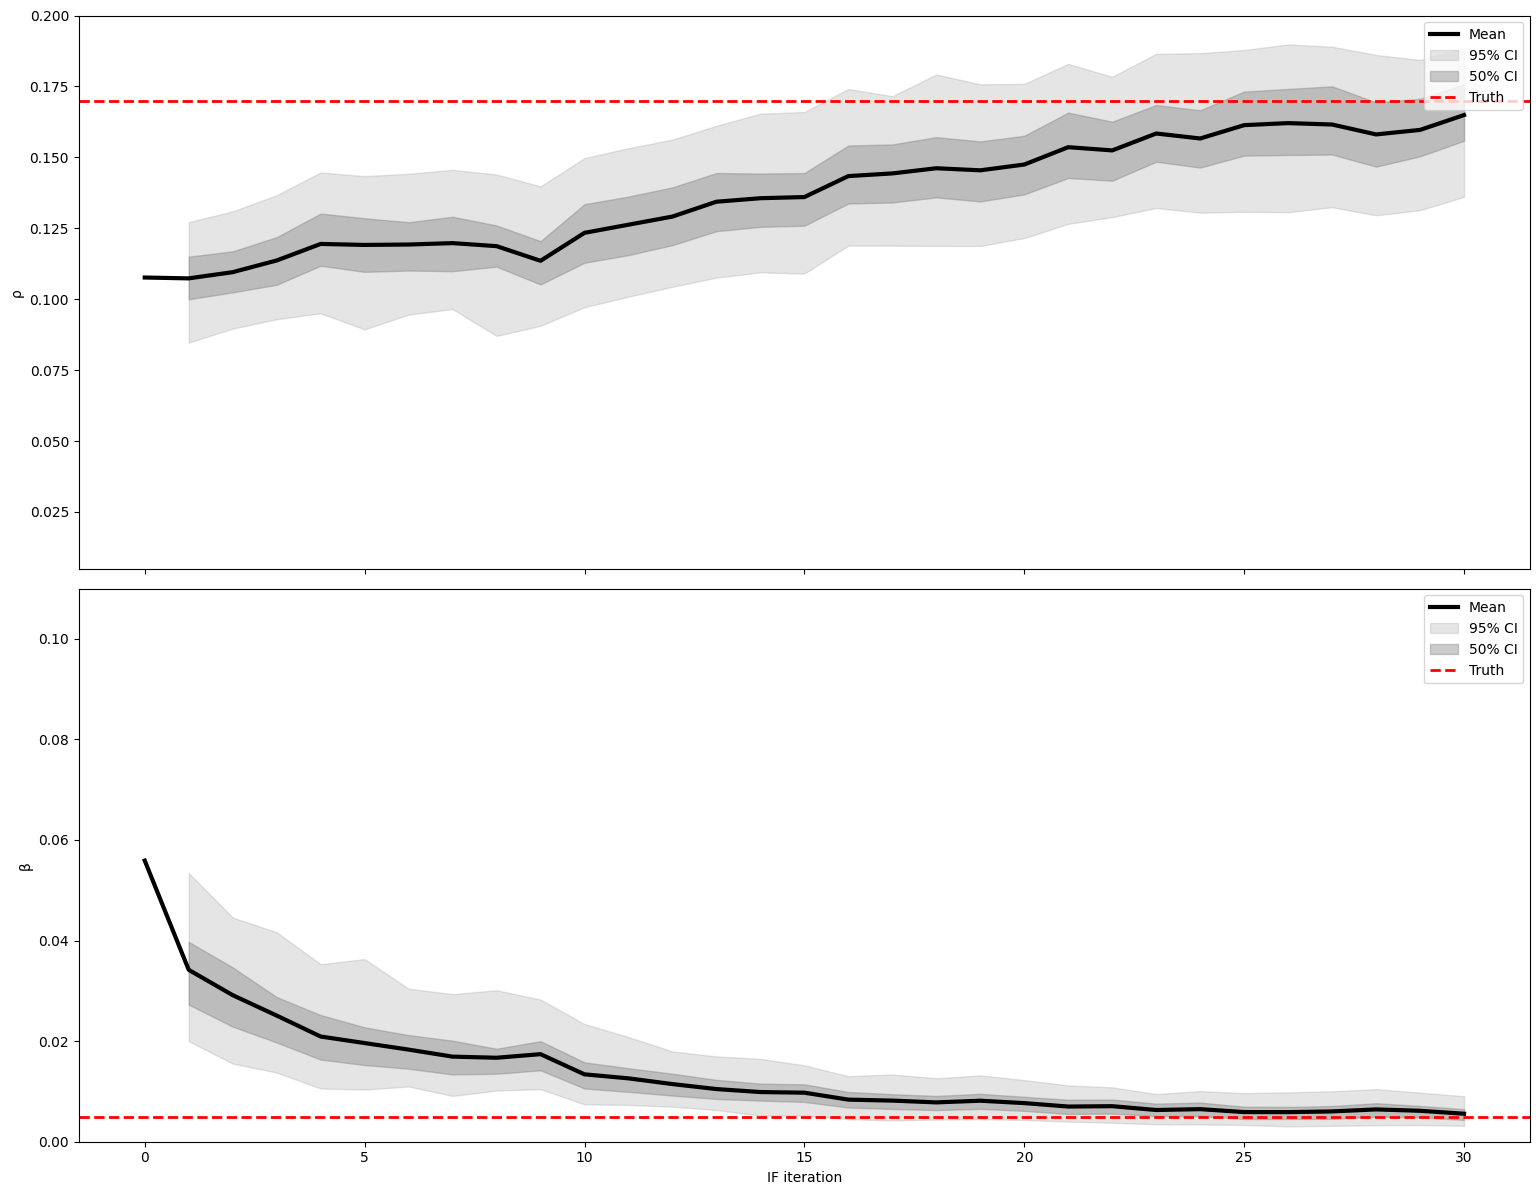

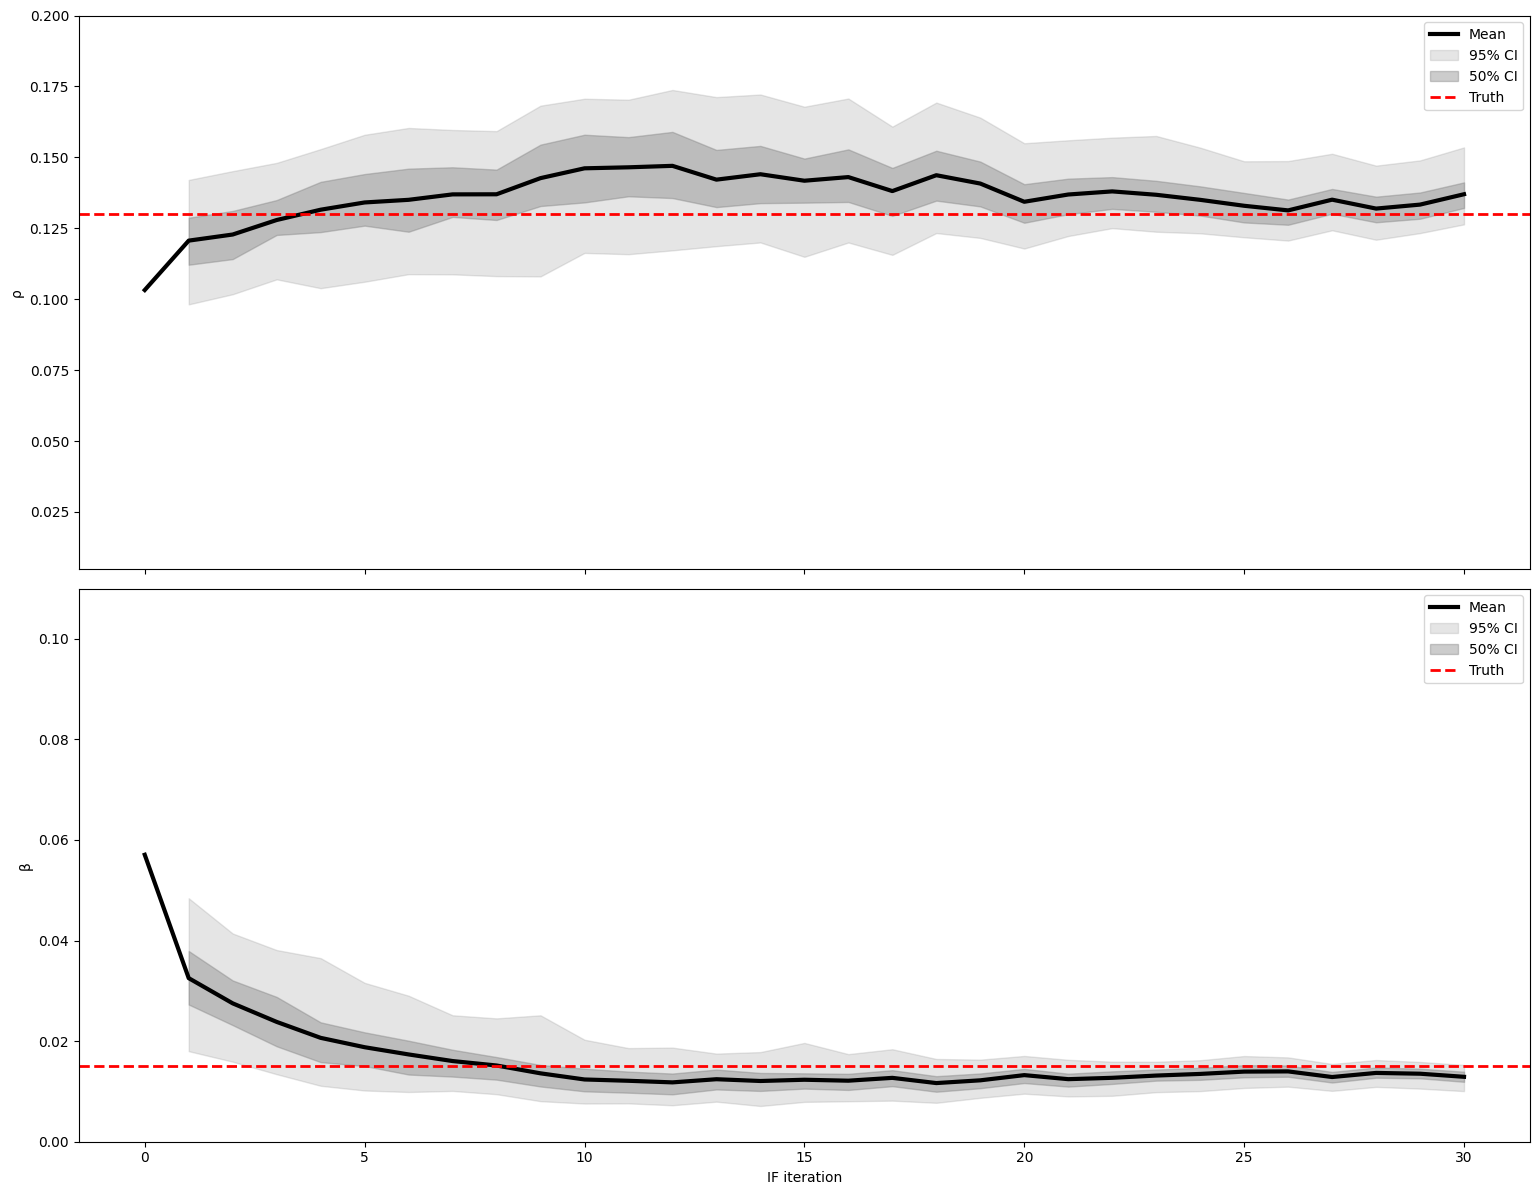

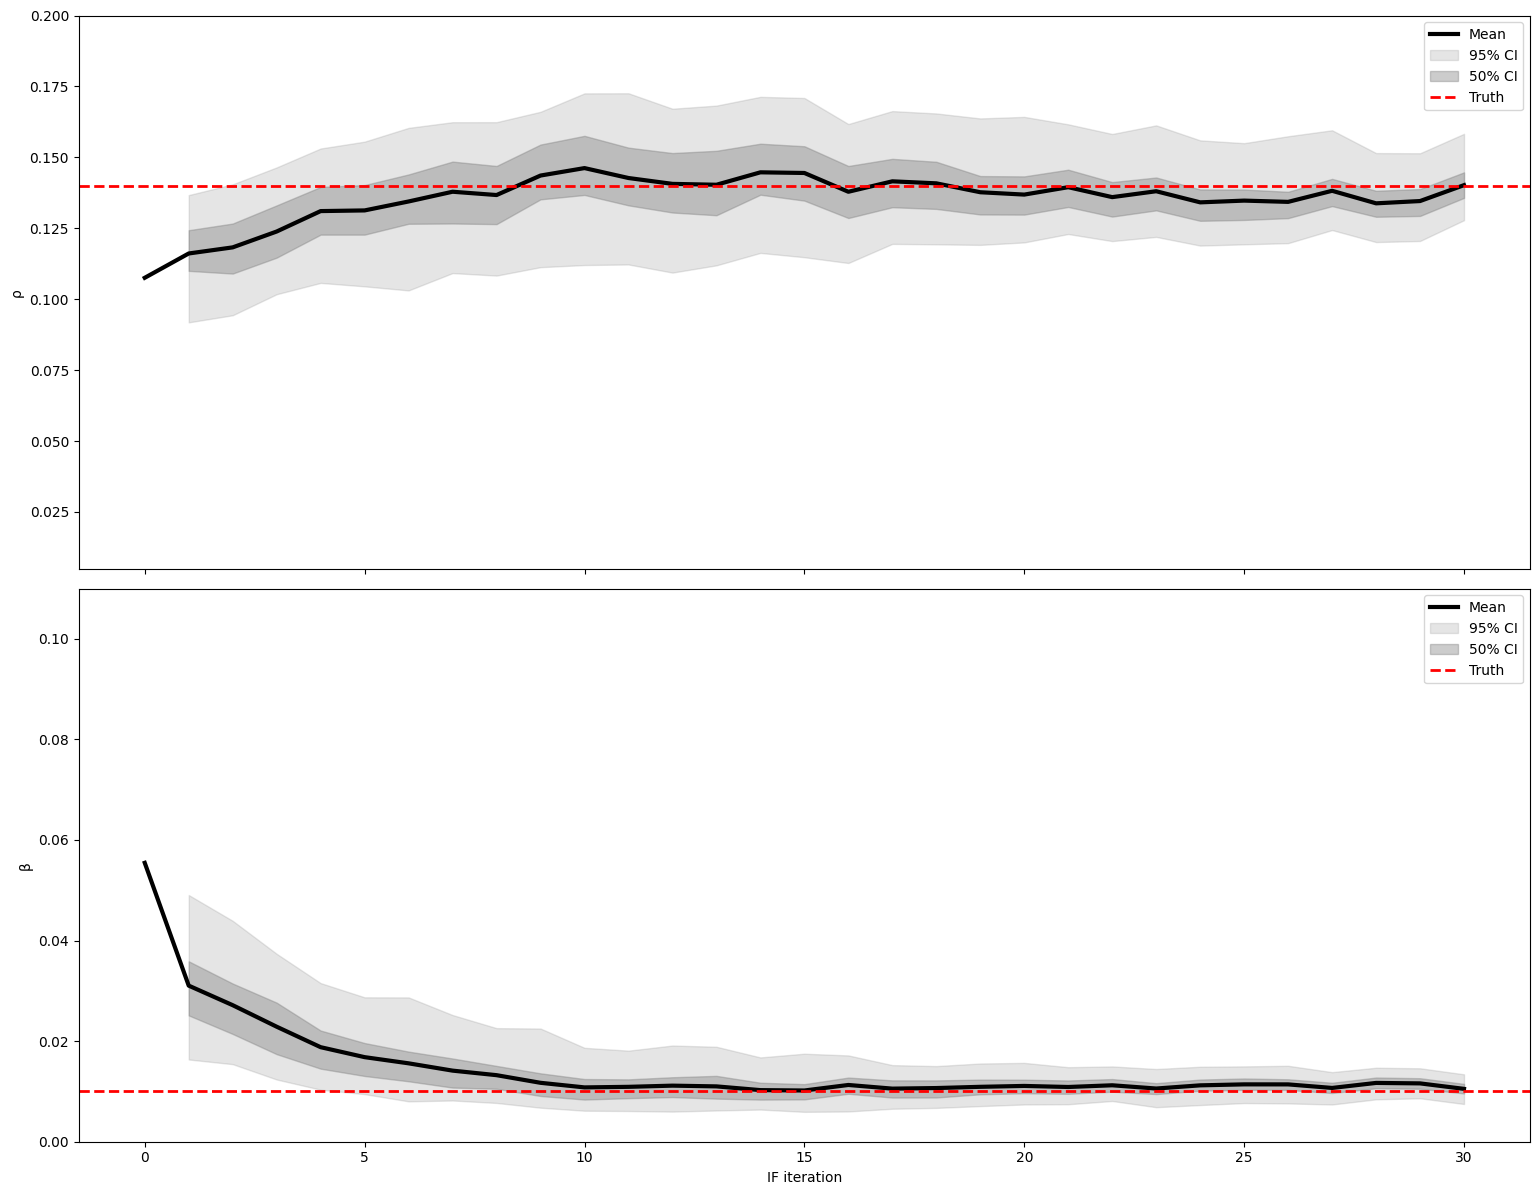

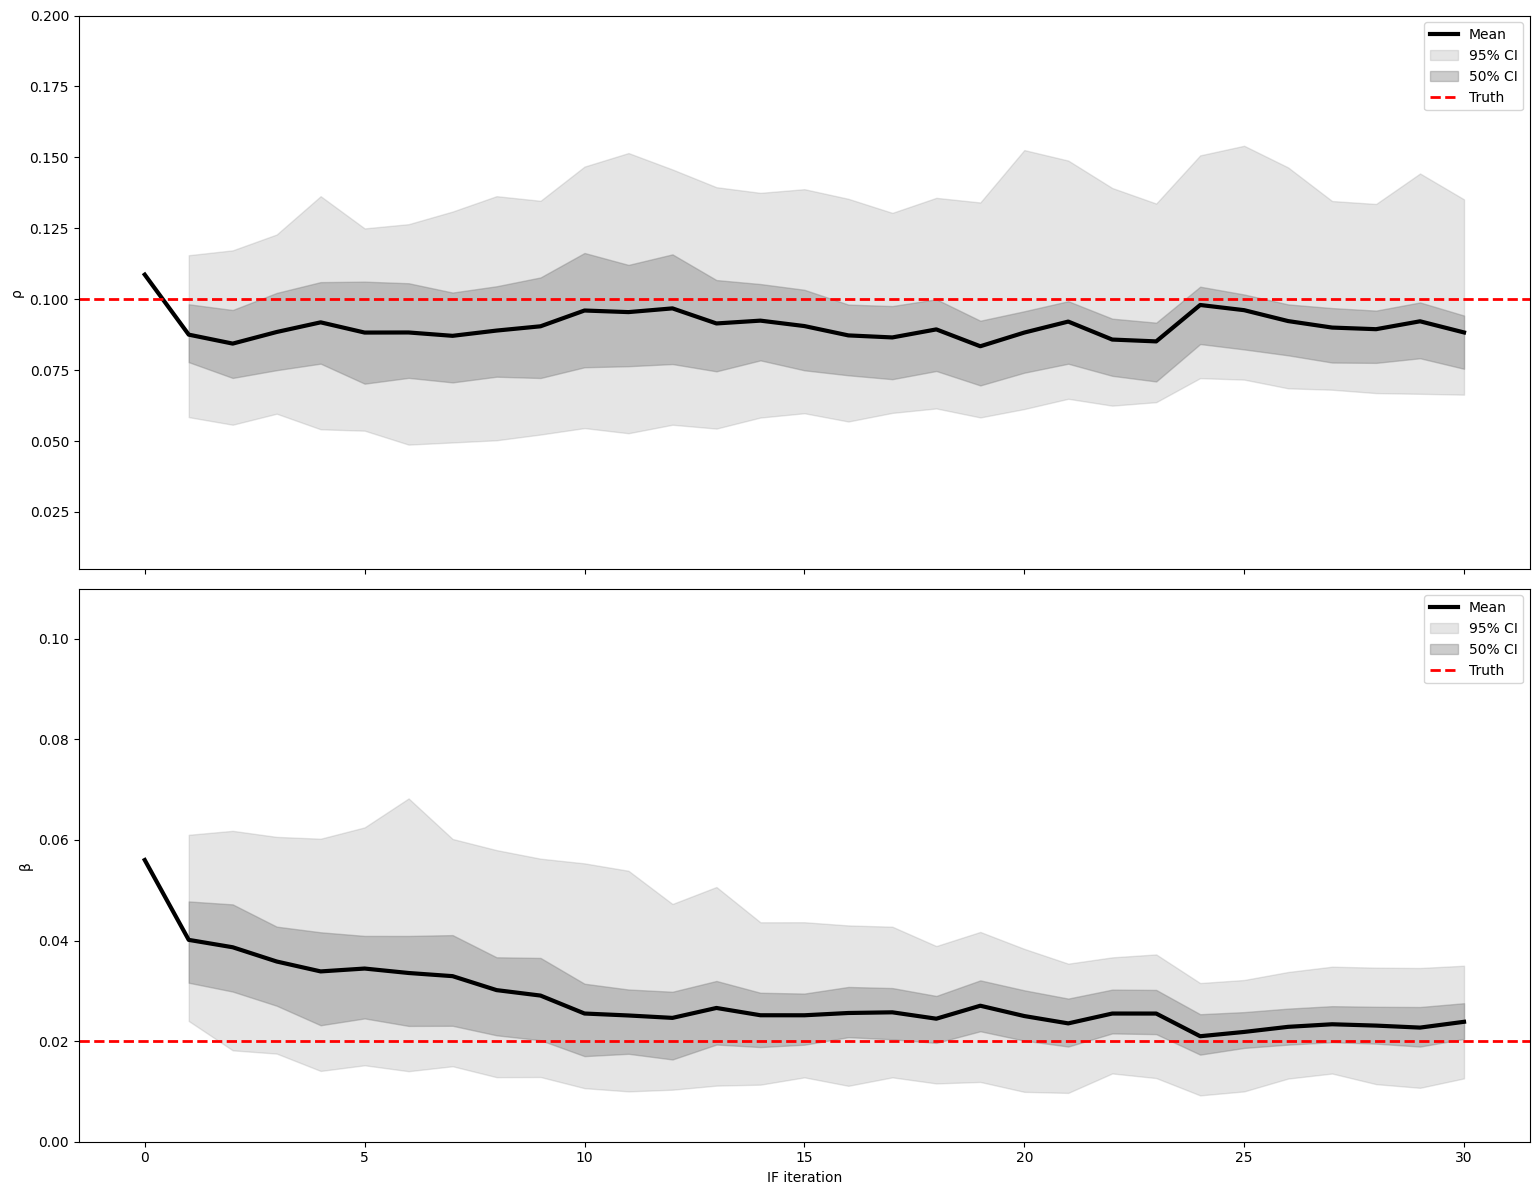

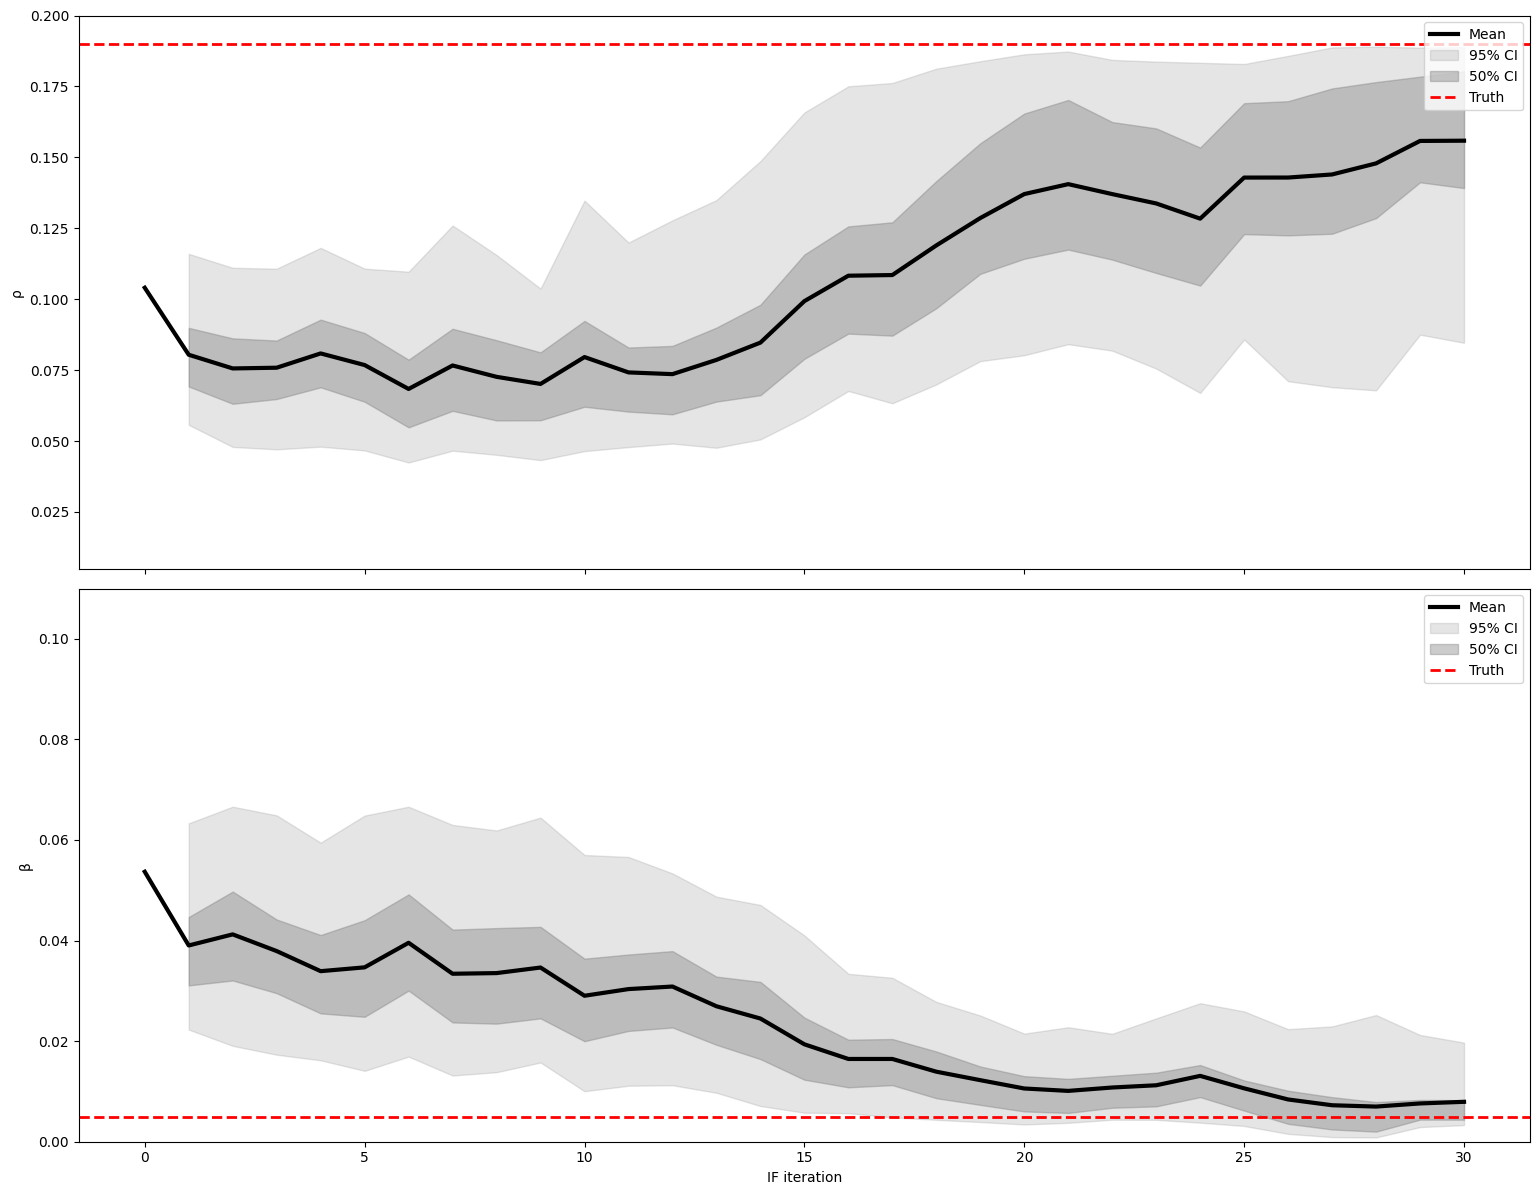

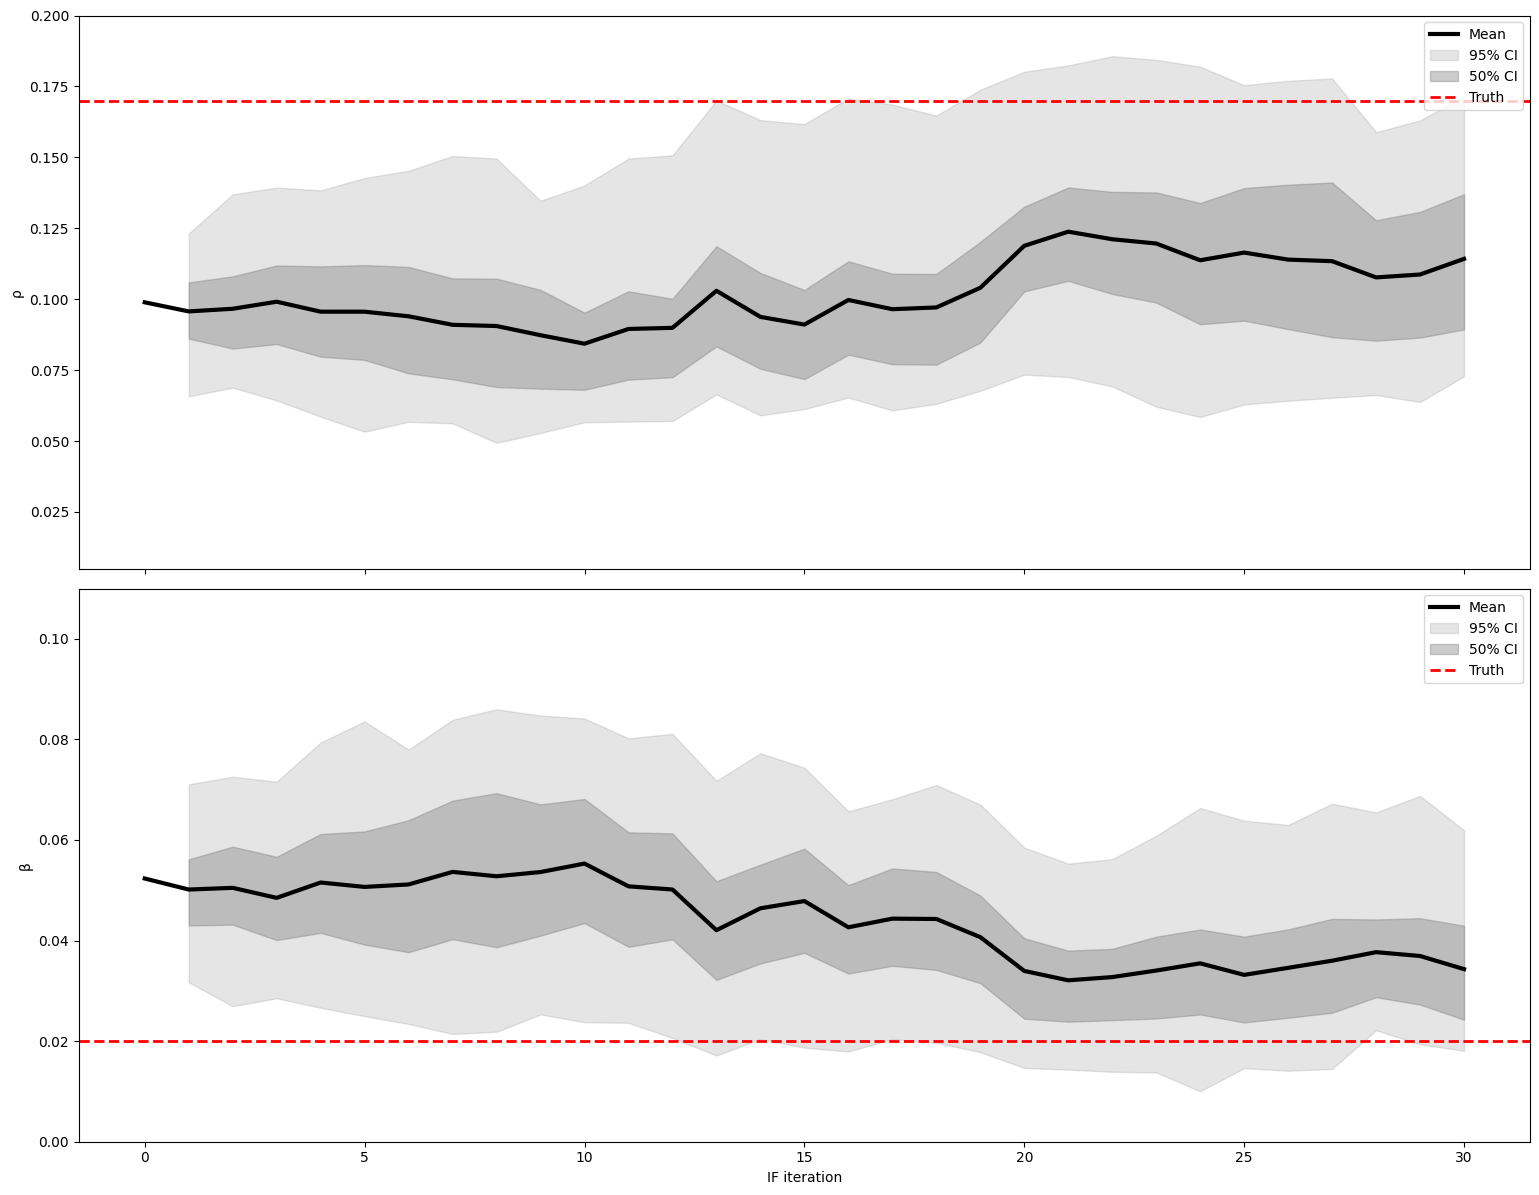

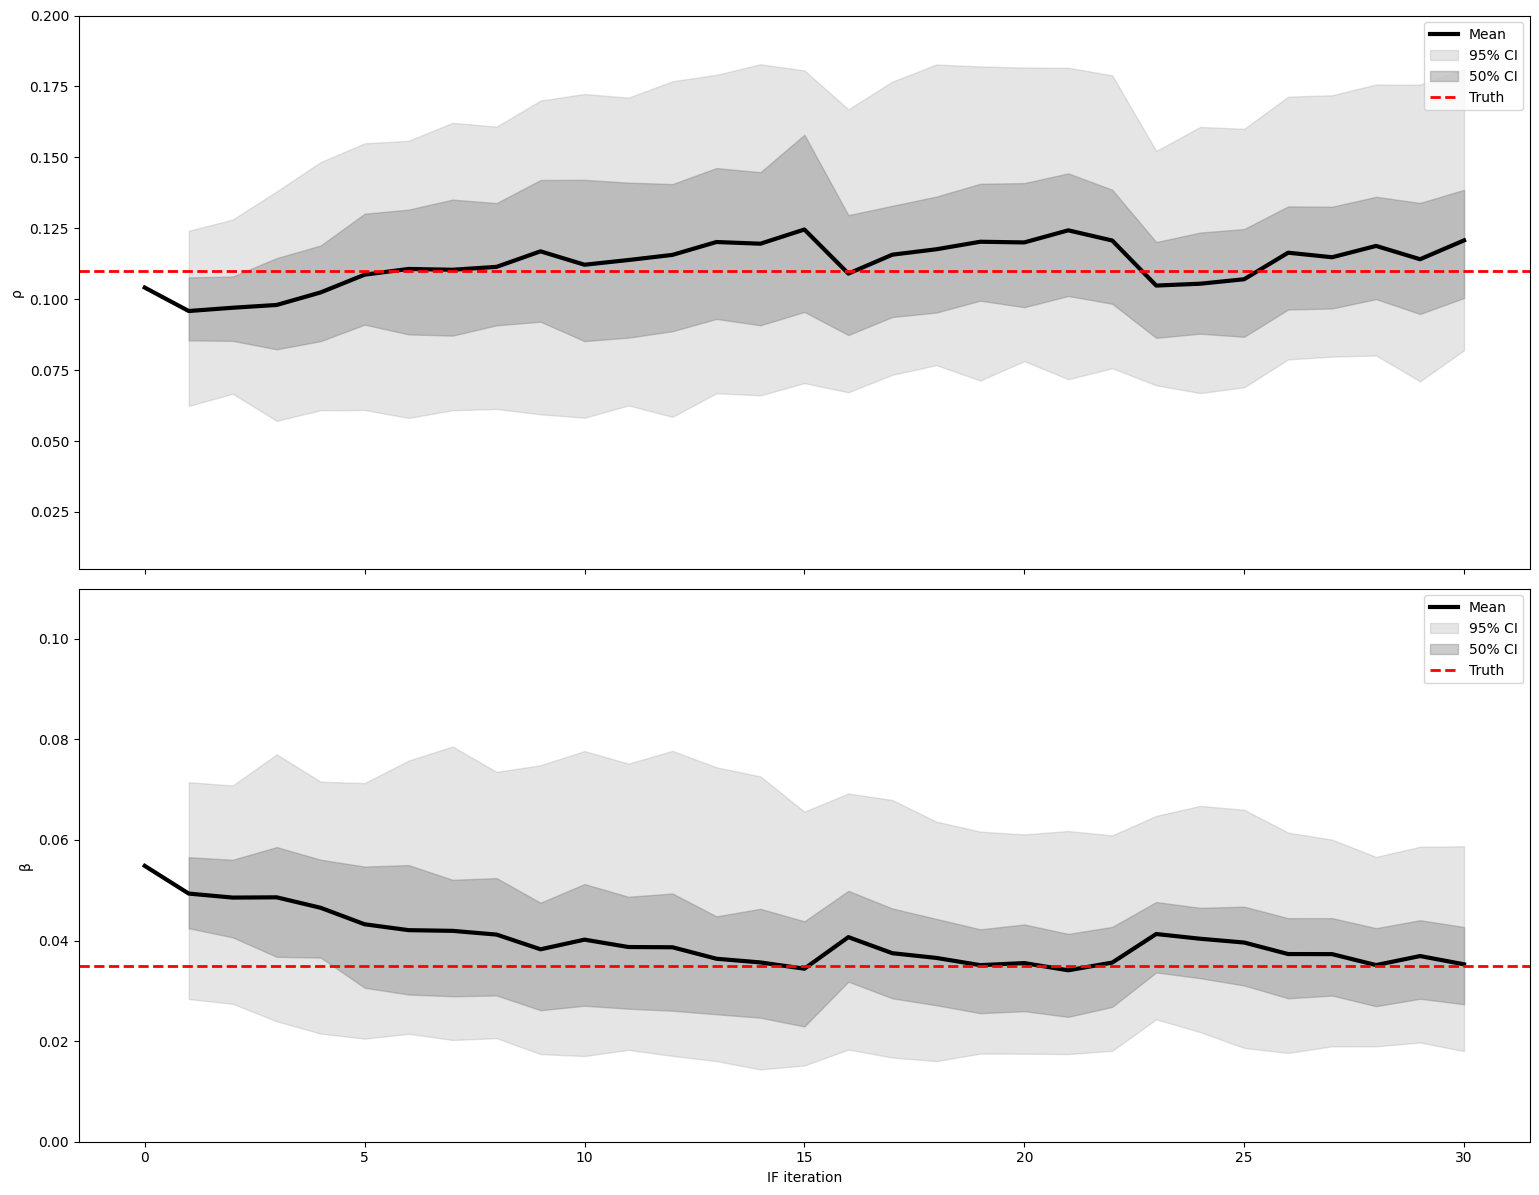

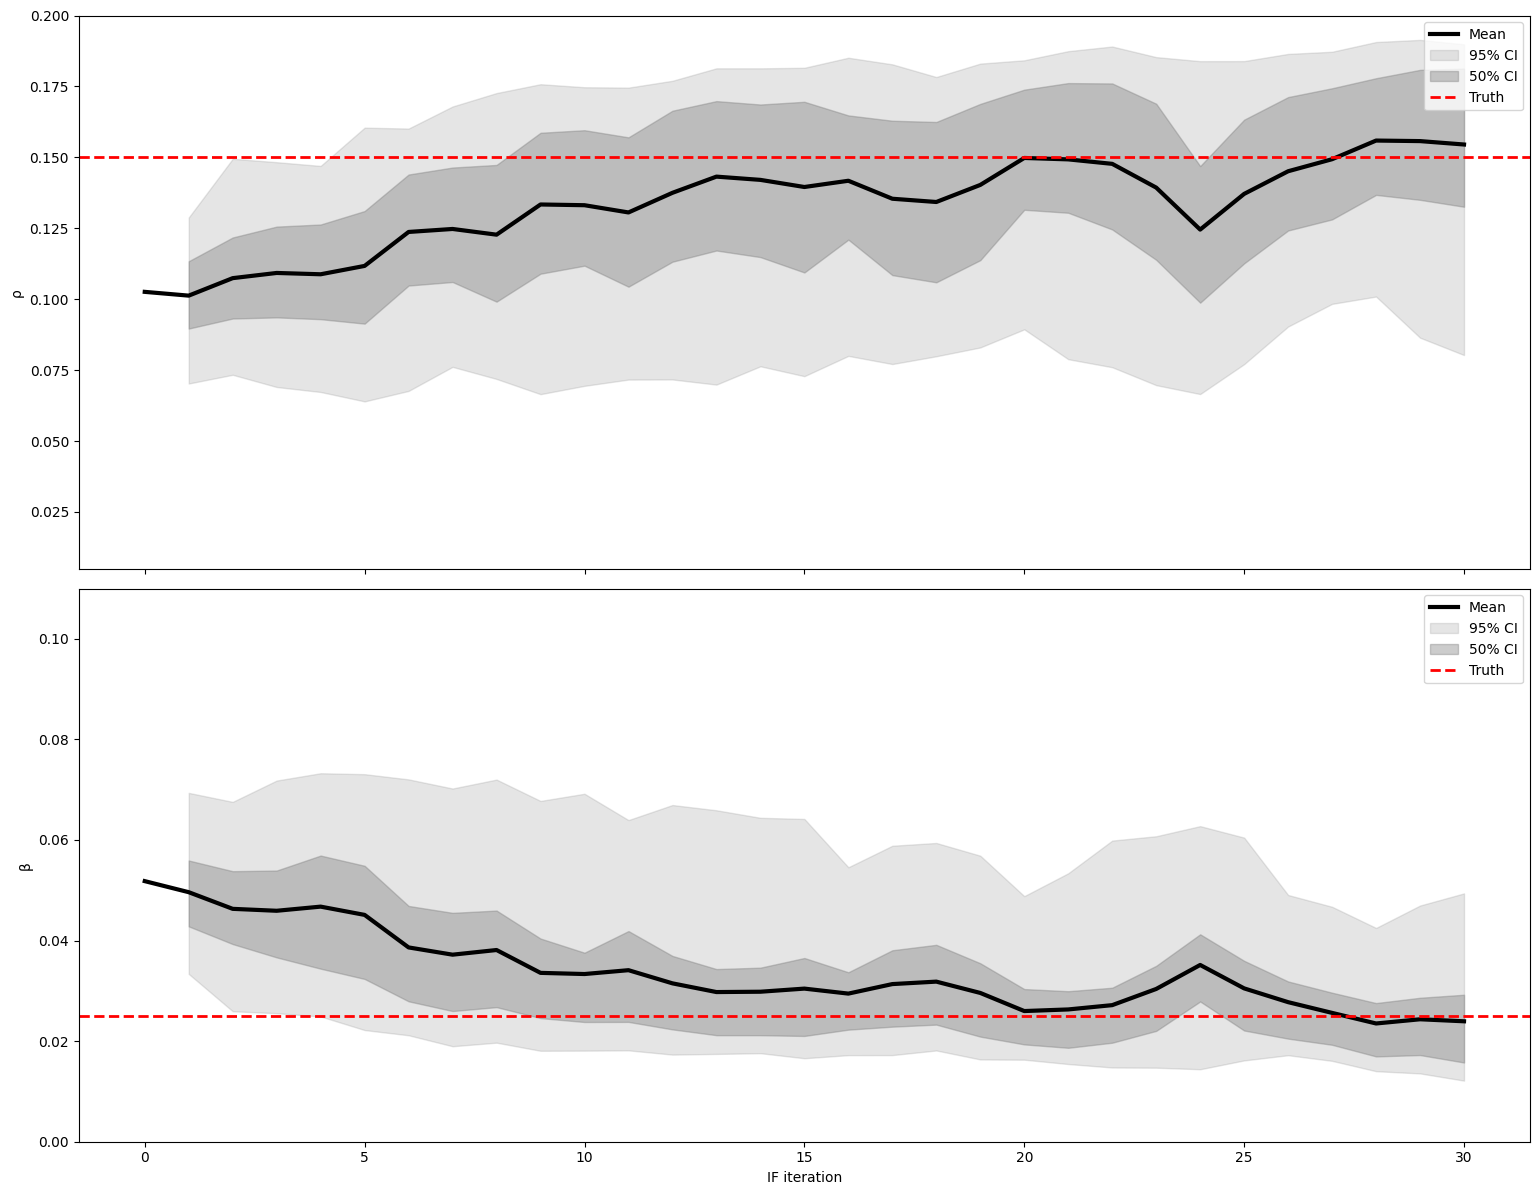

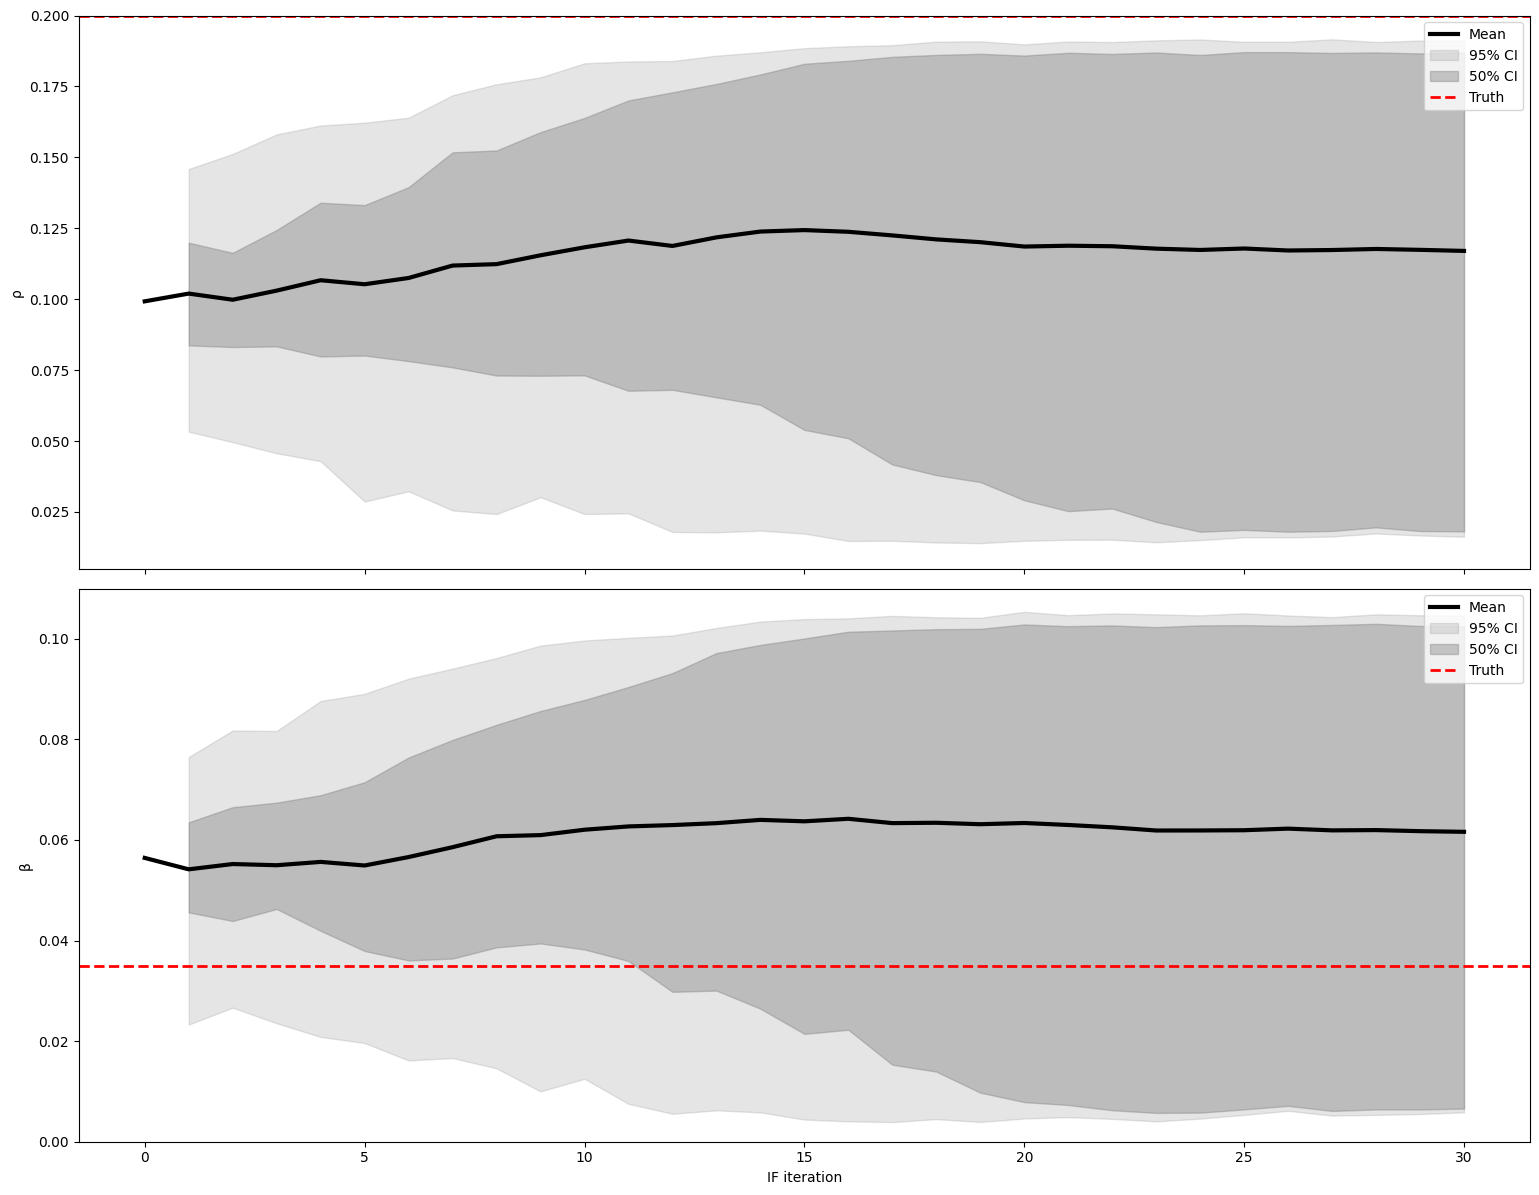

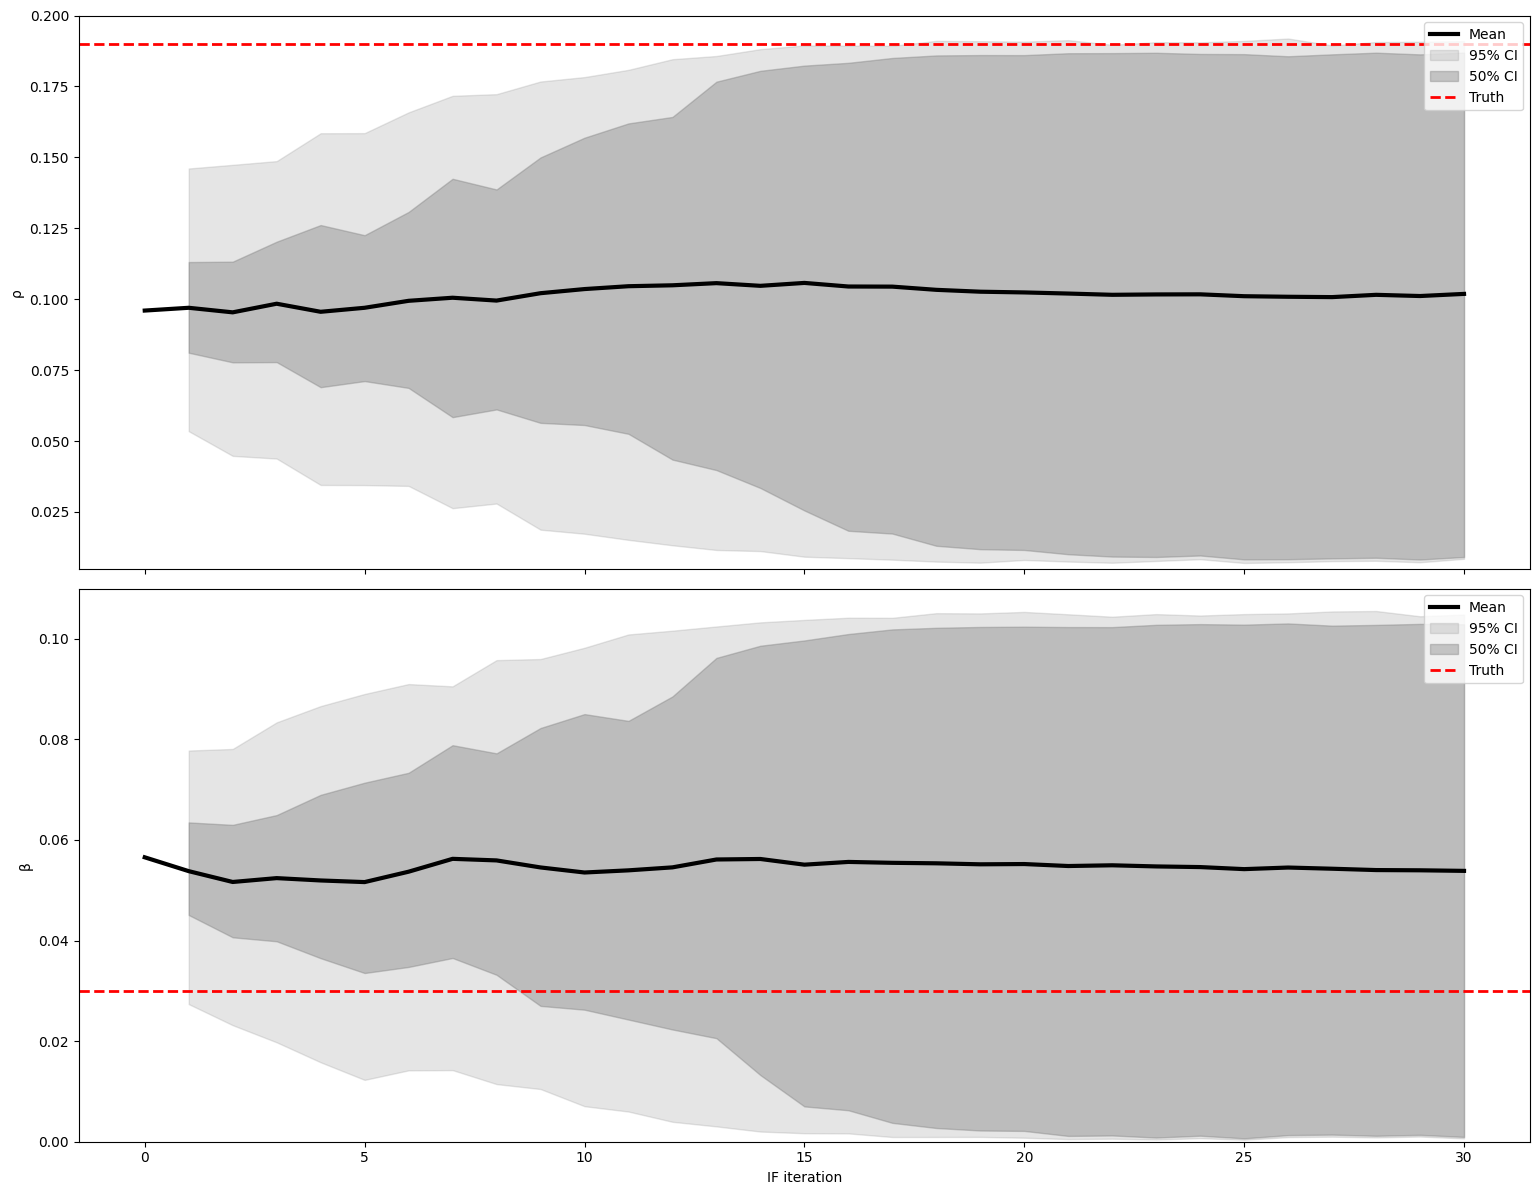

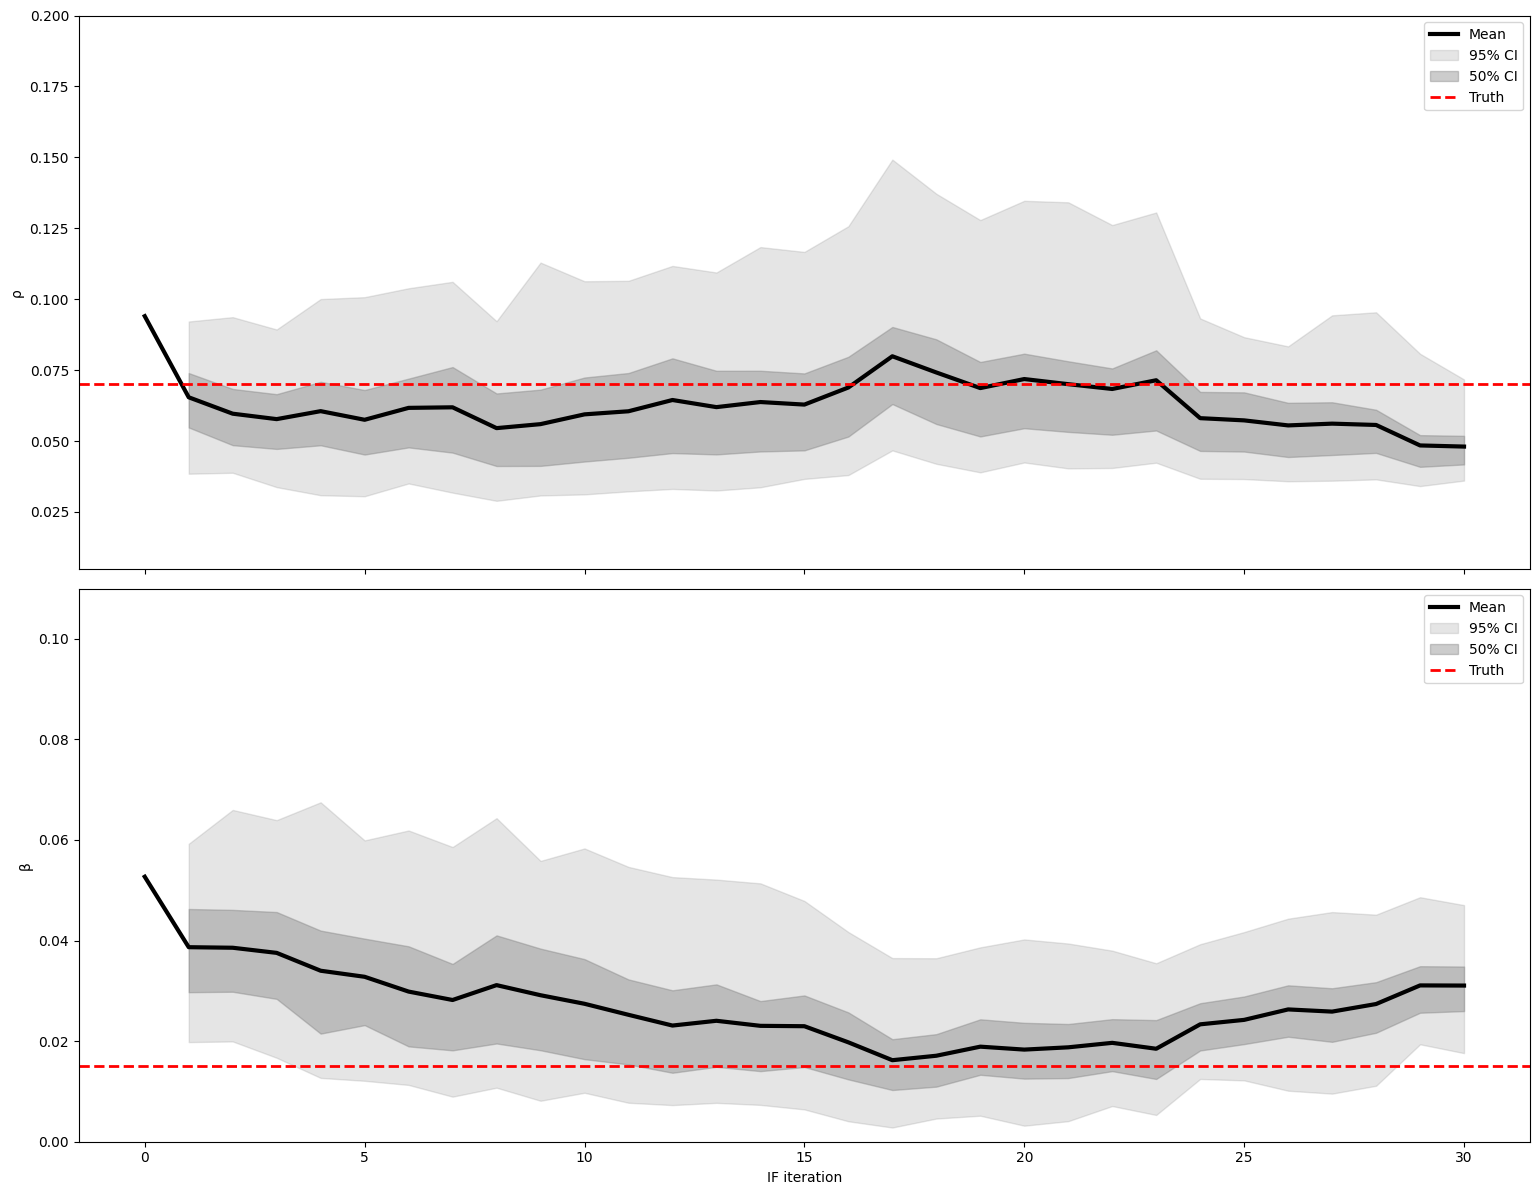

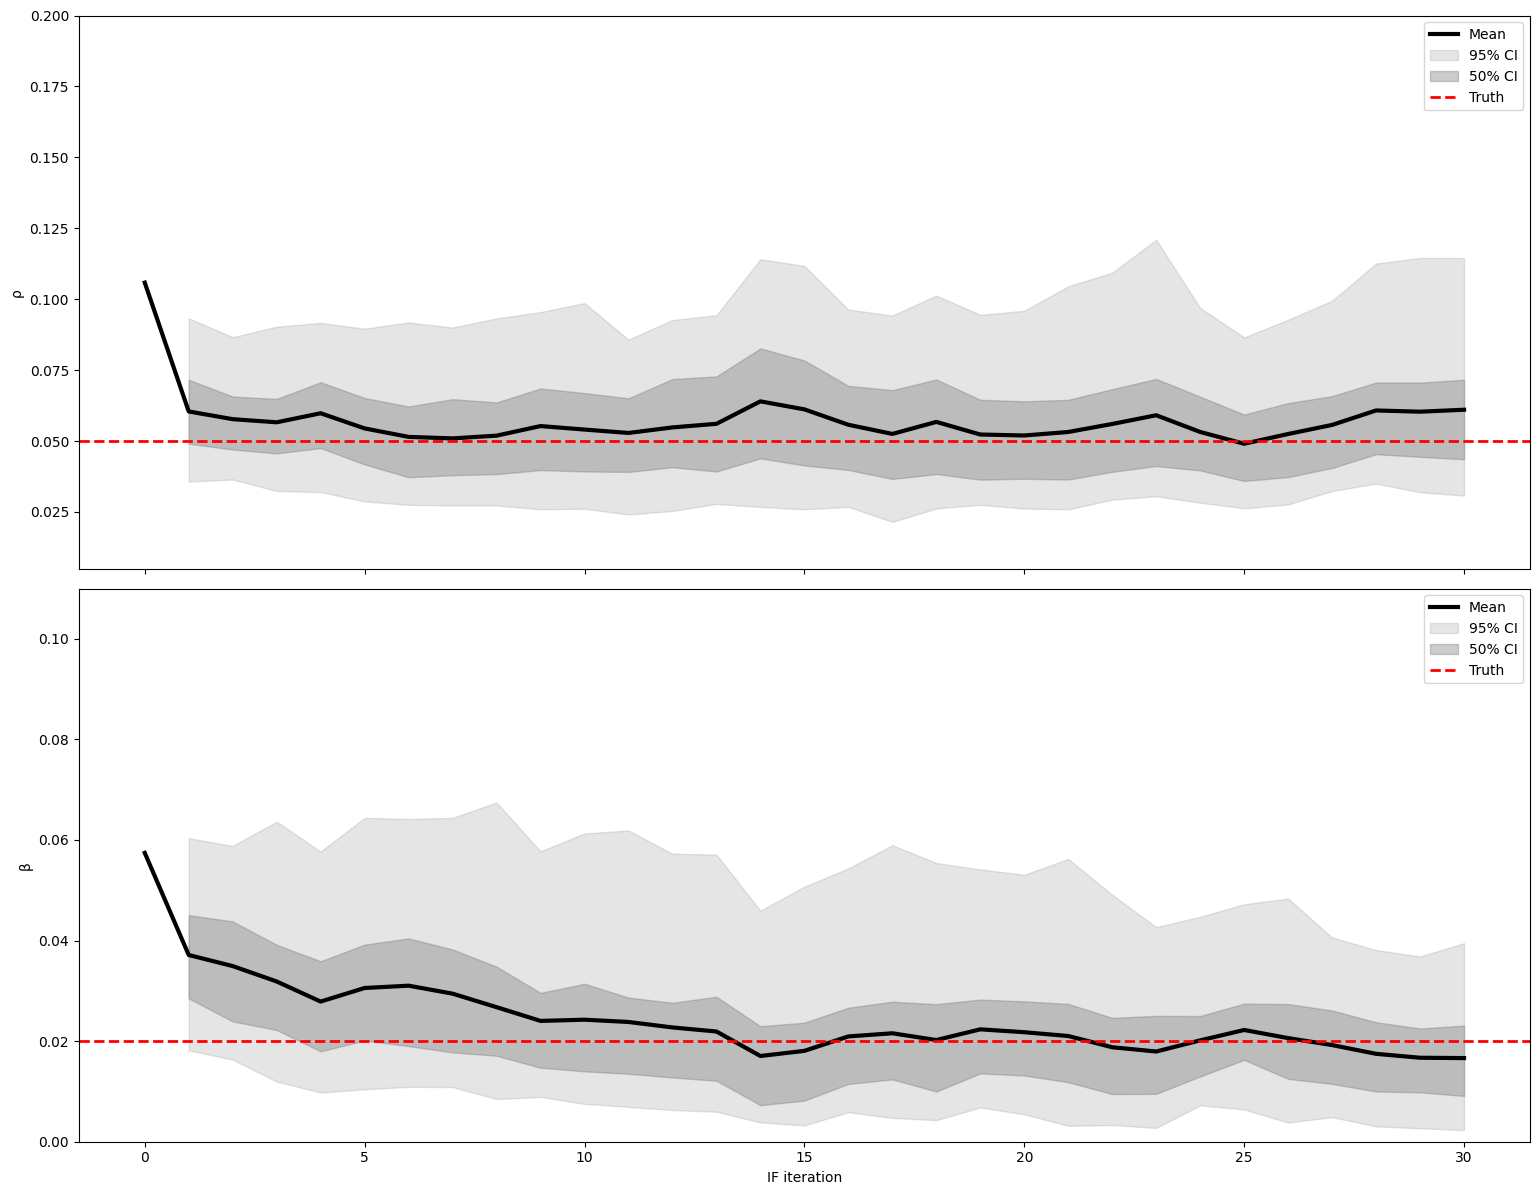

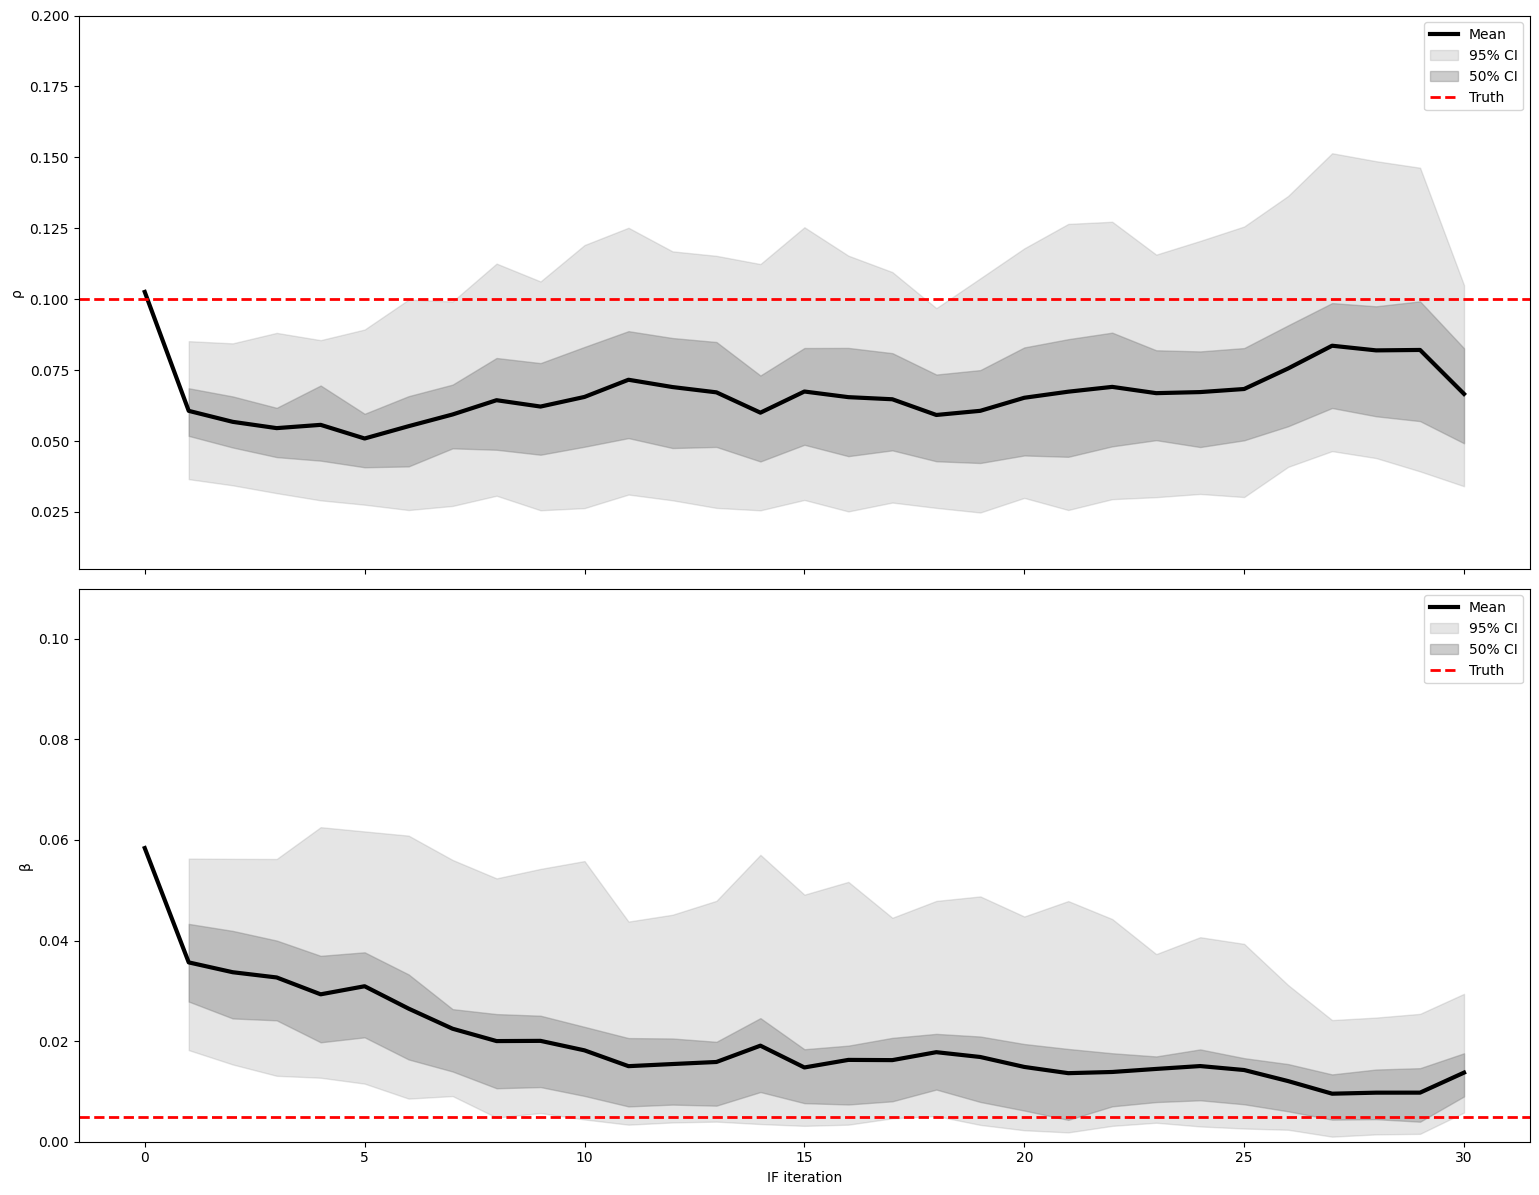

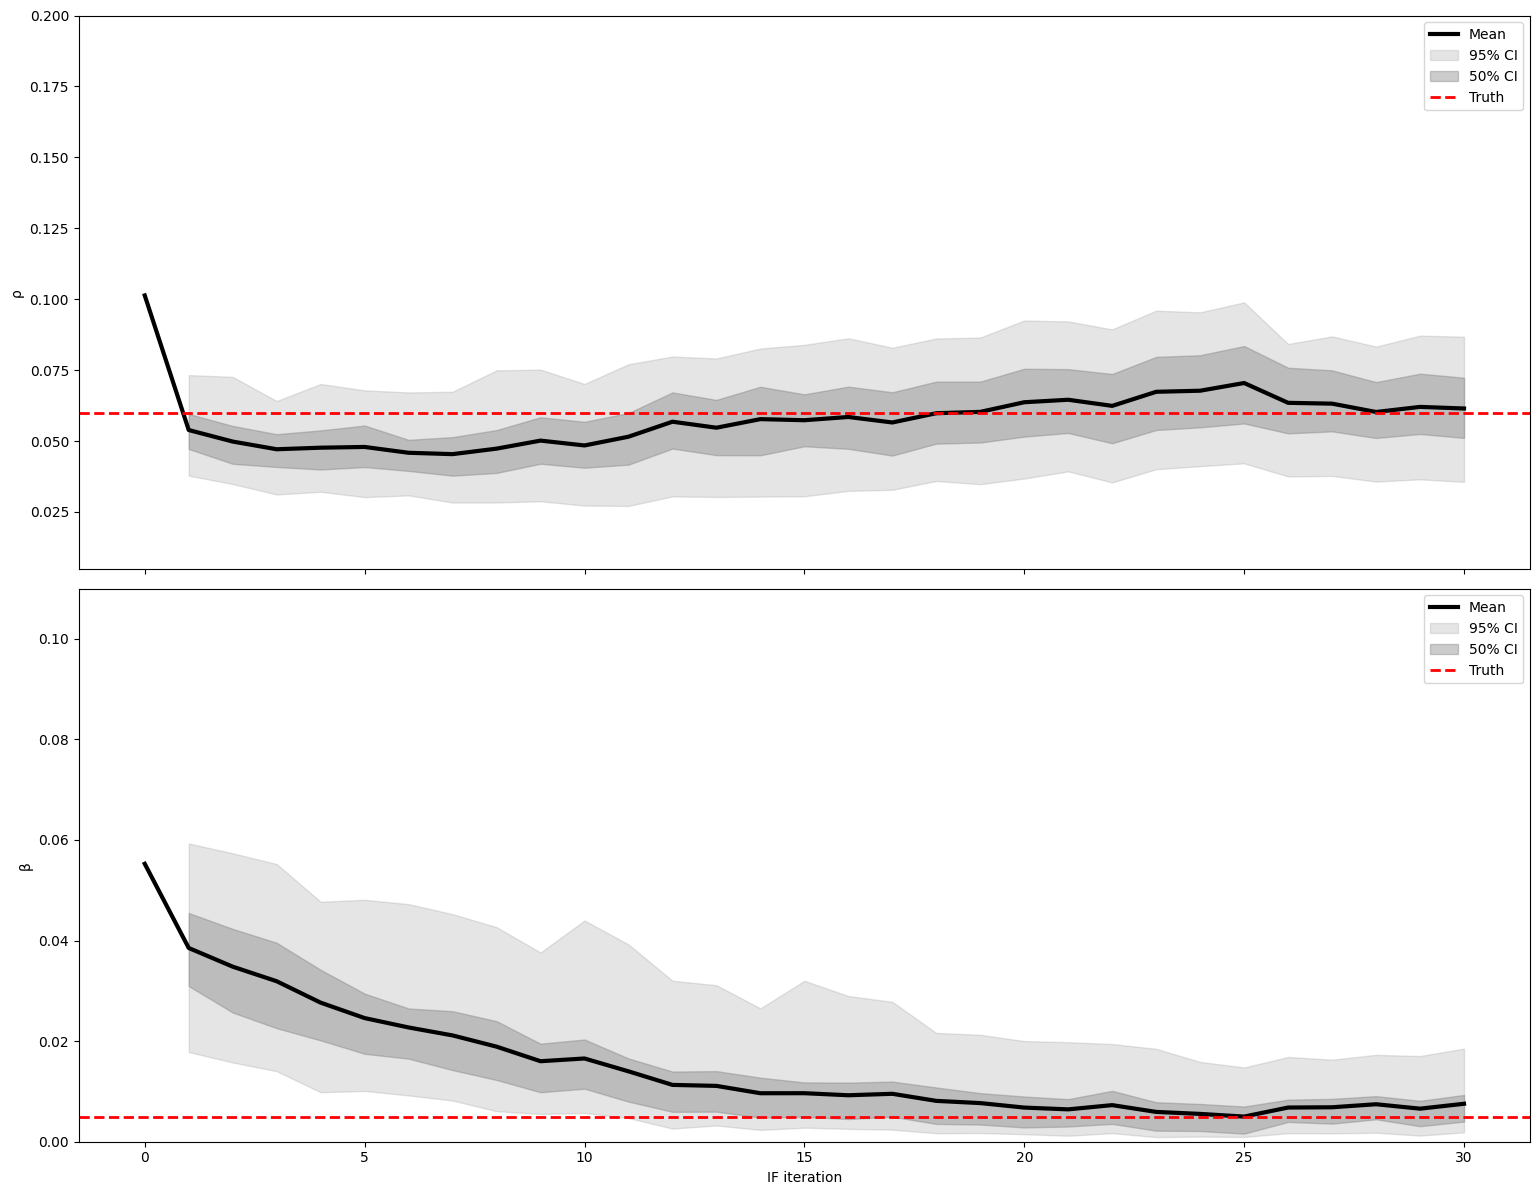

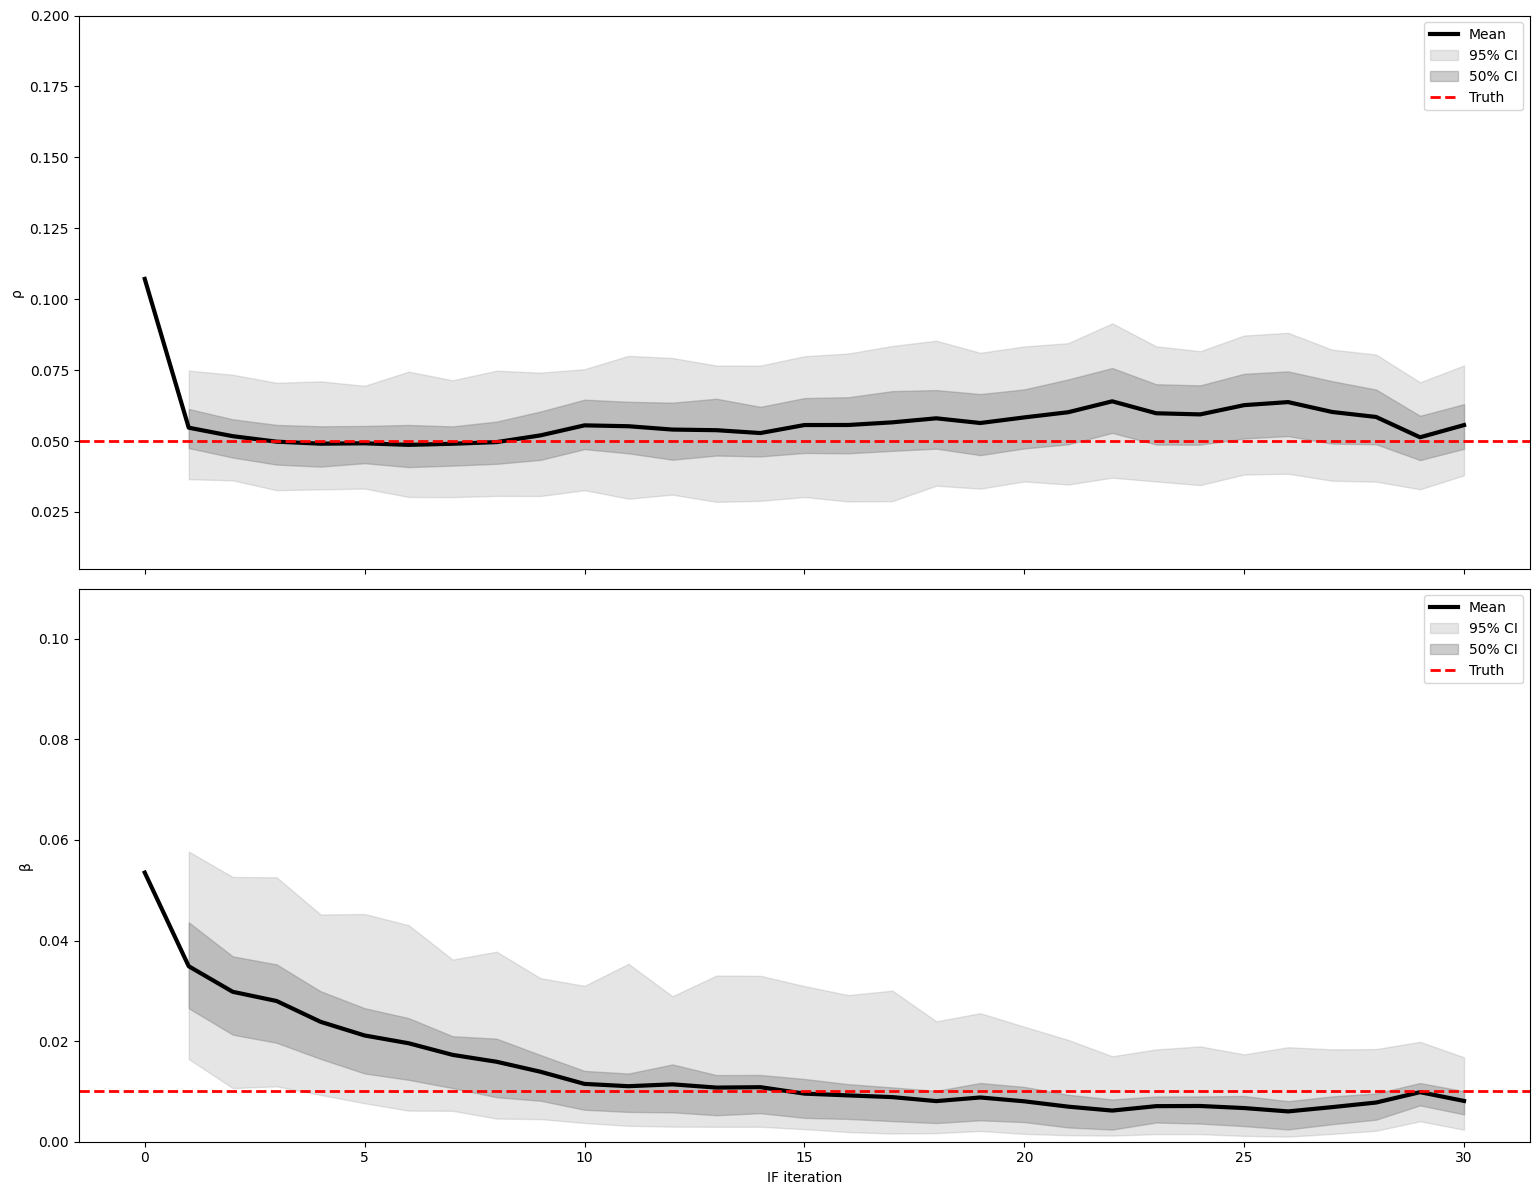

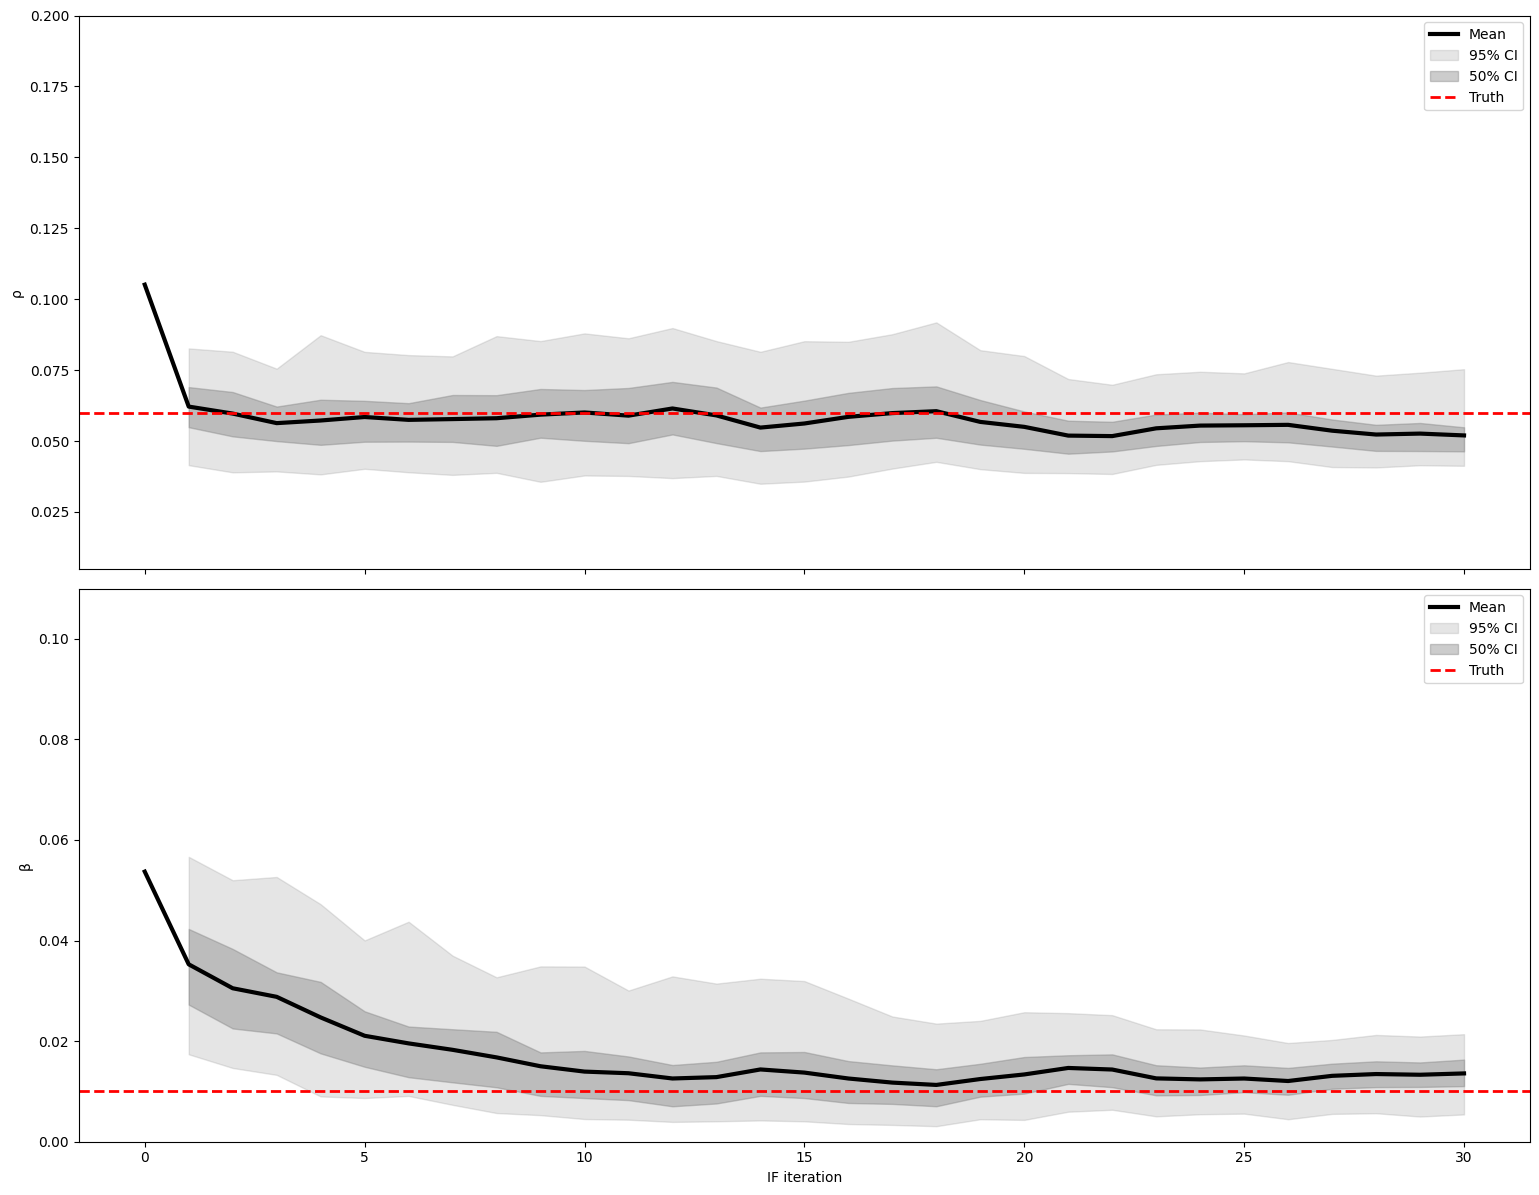

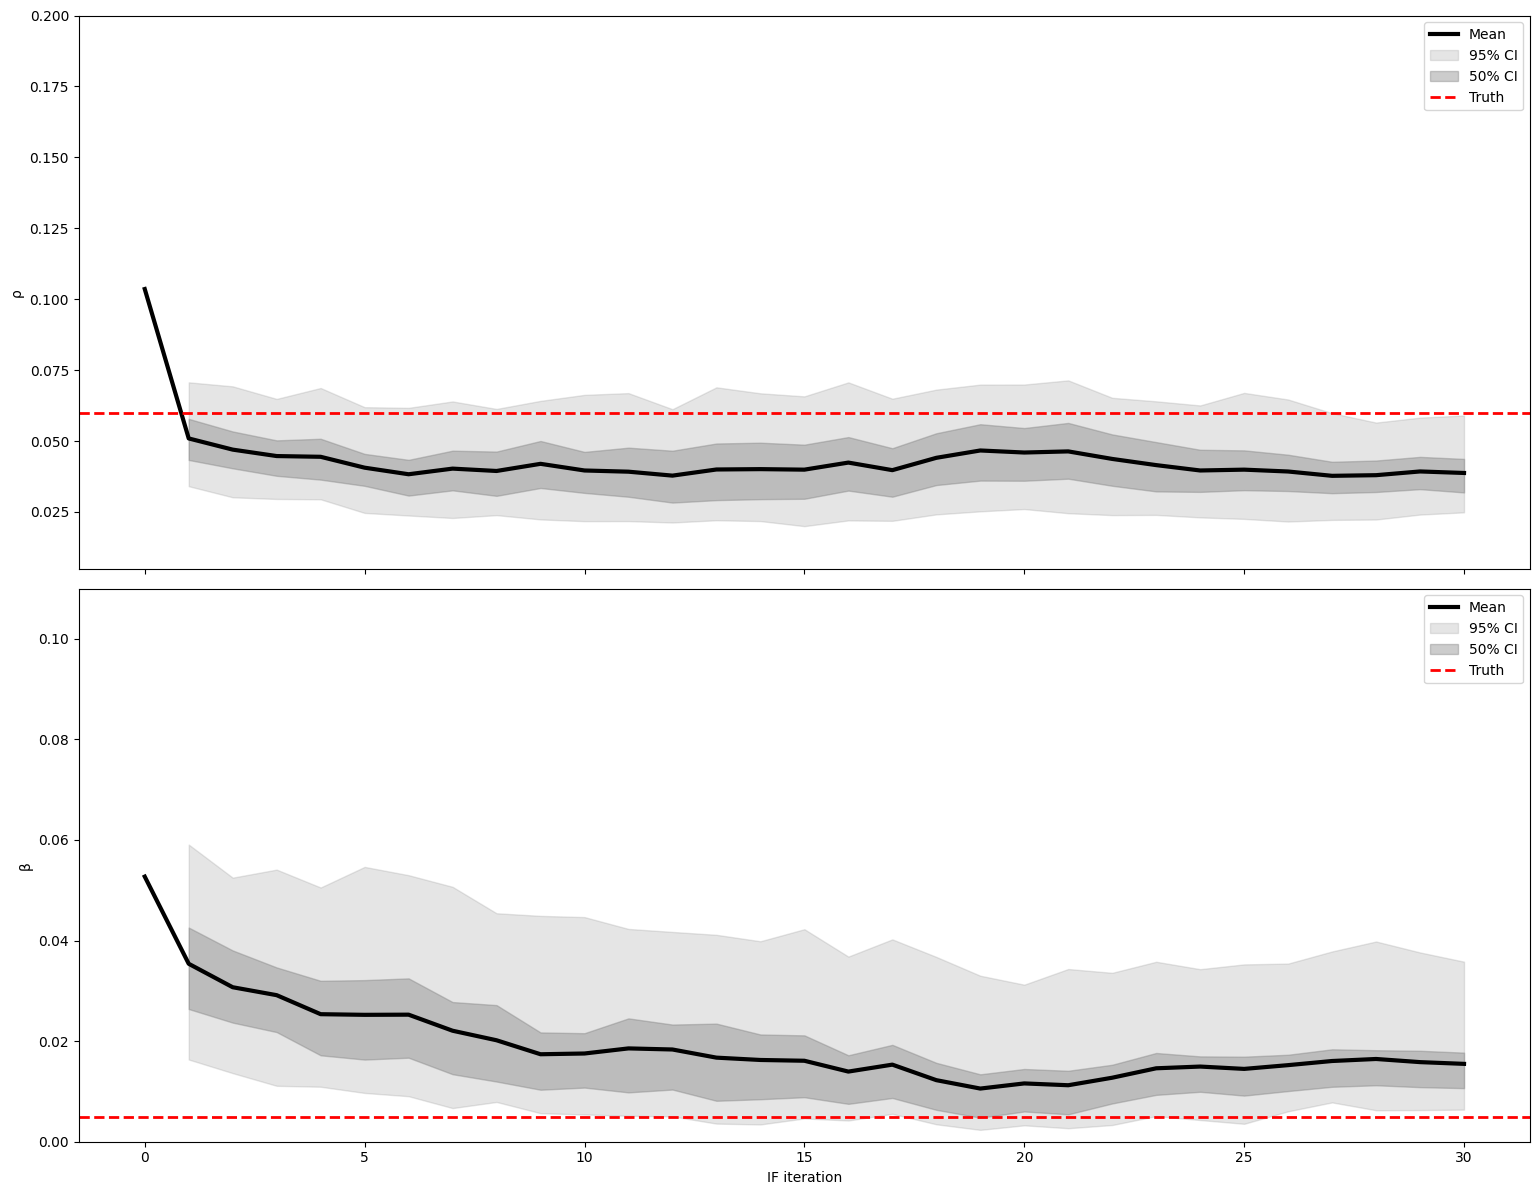

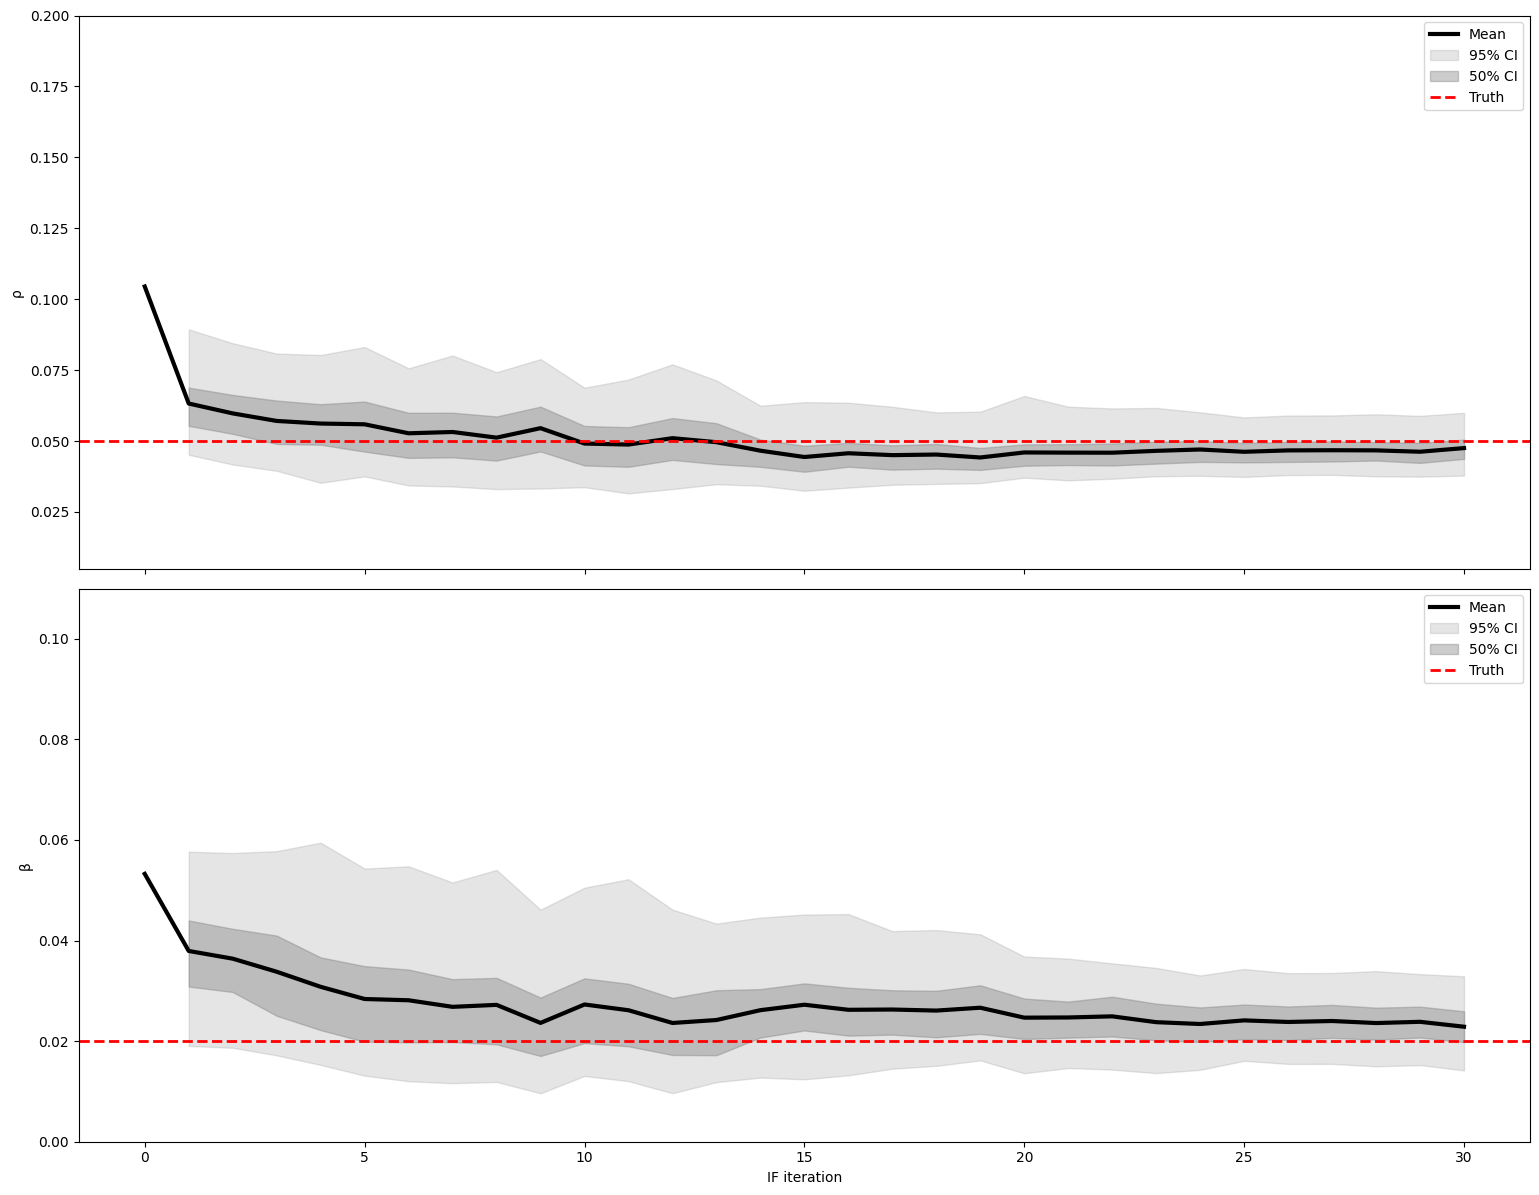

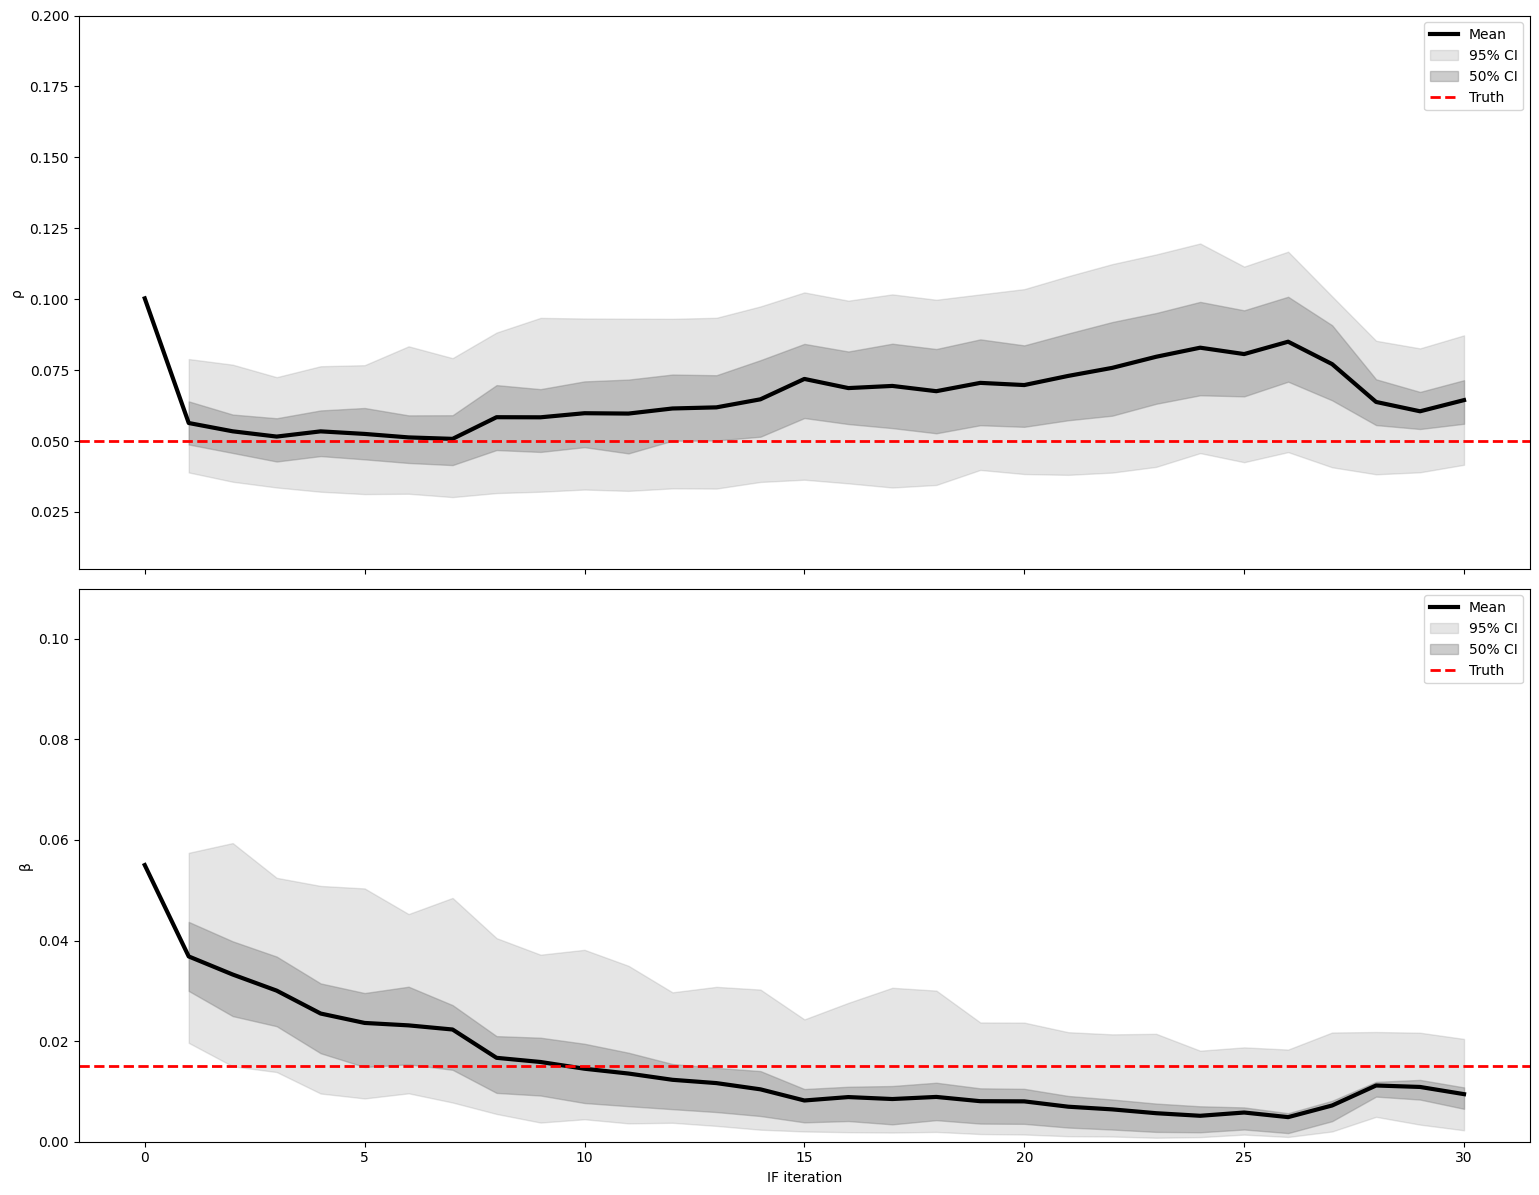

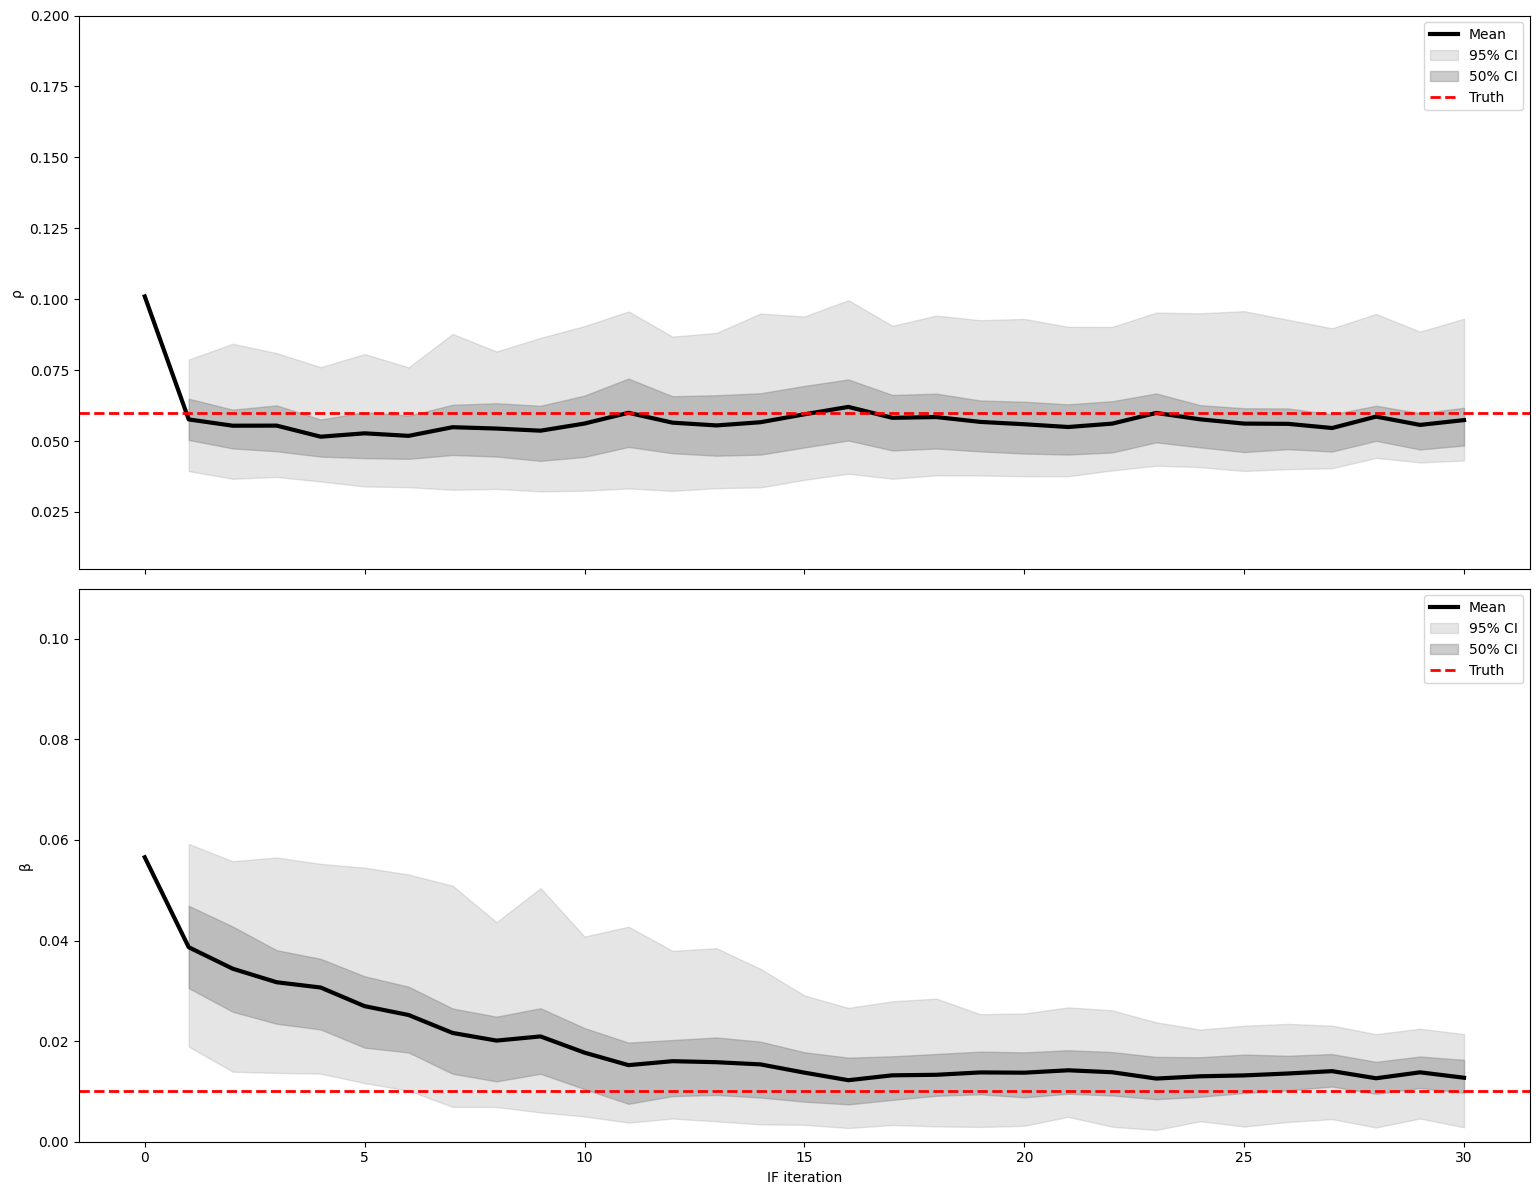

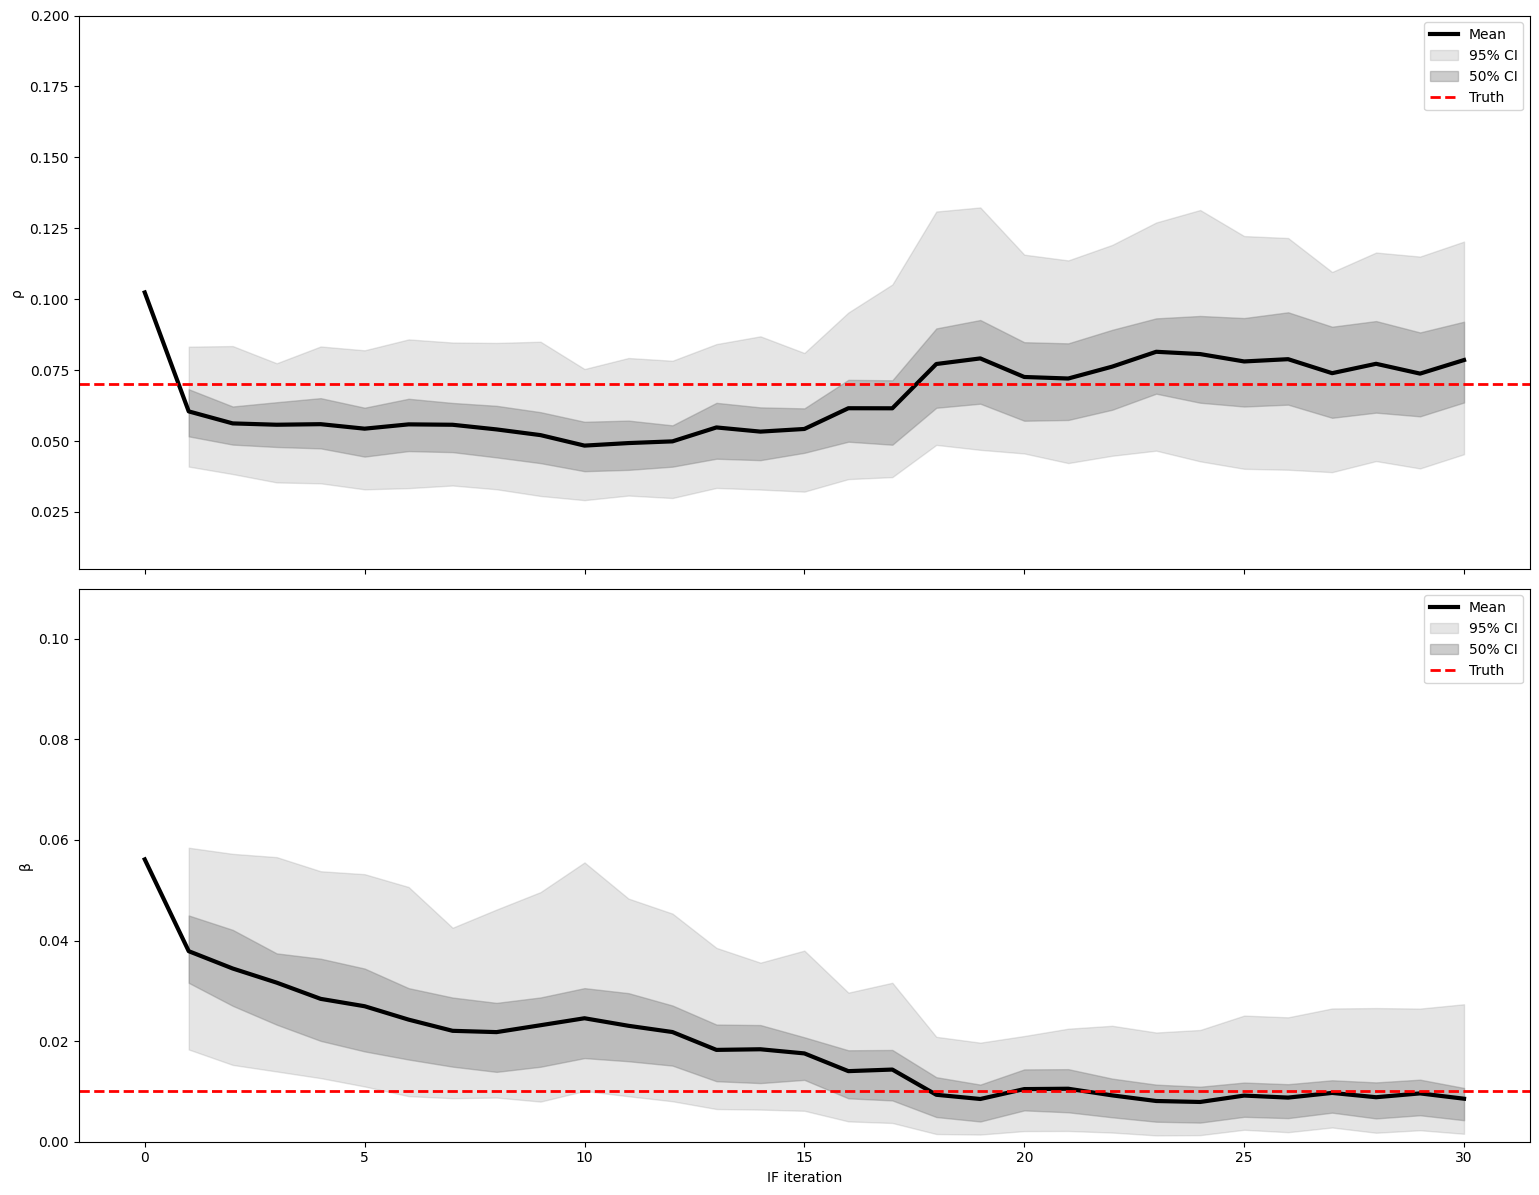

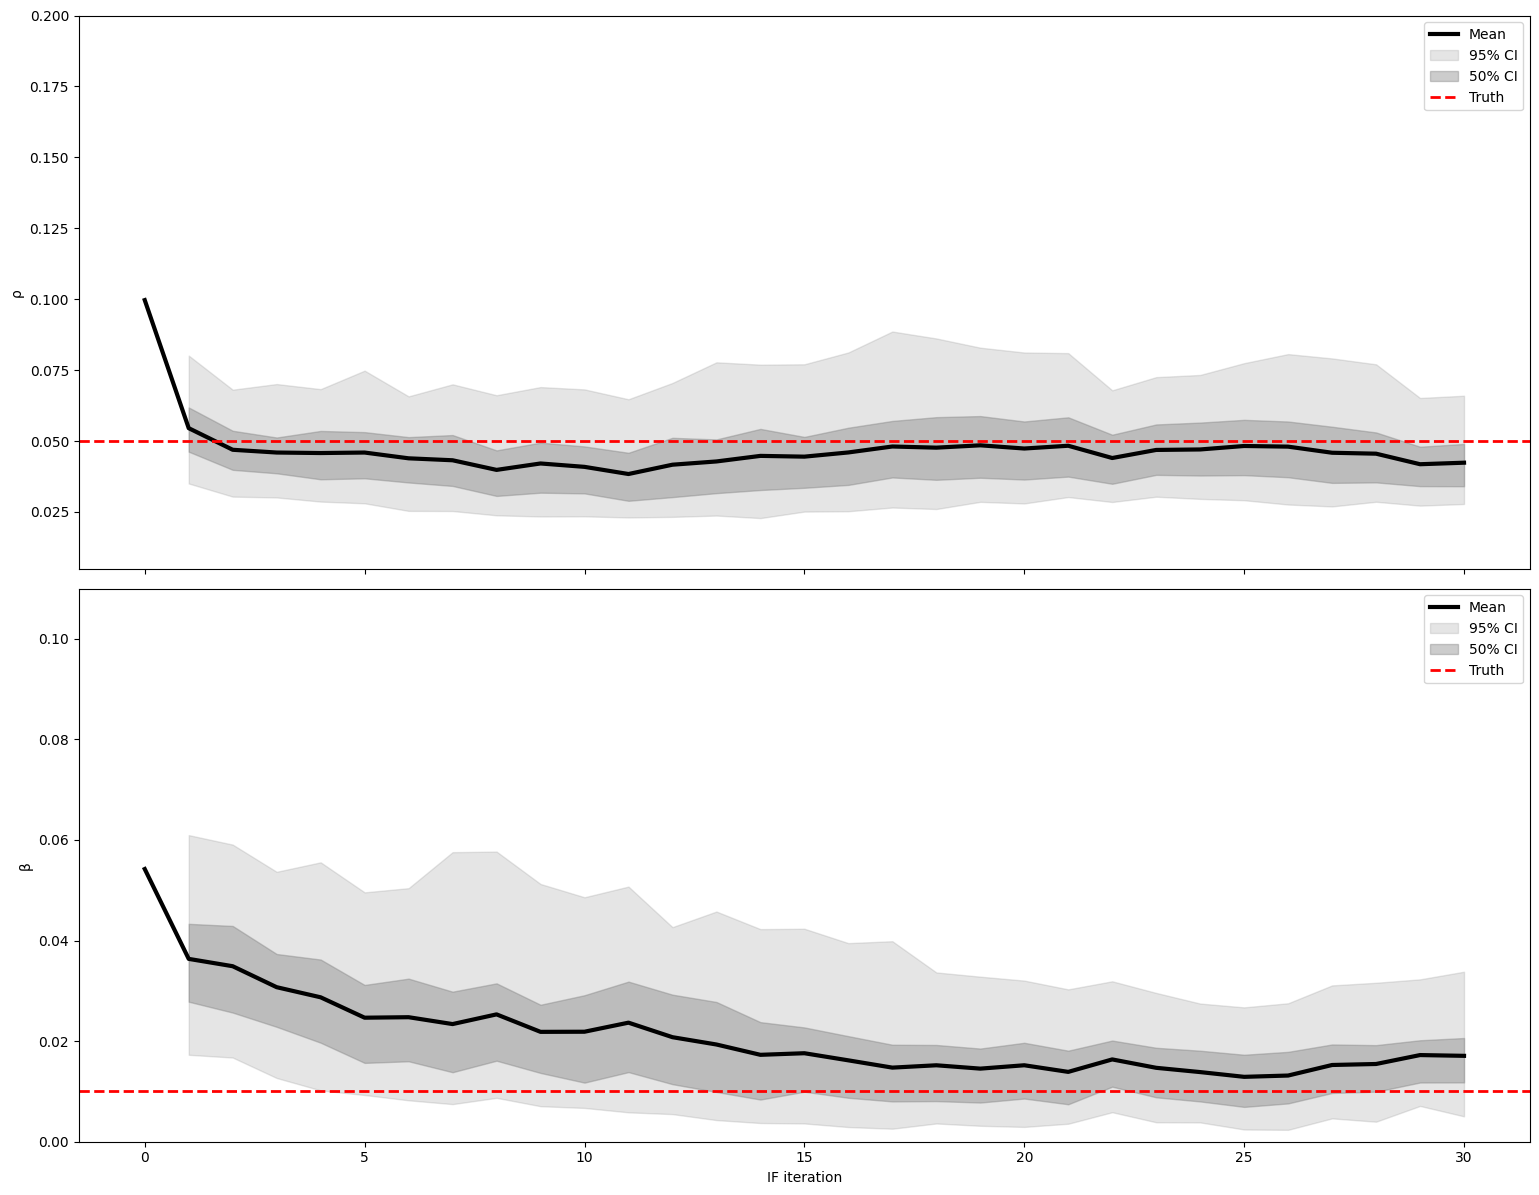

In [5]:
from models import amr_abm, observe_cluster_individual

if_settings = {
        "Nif"                : 30,          # number of iterations of the IF
        "type_cooling"       : "geometric", # type of cooling schedule
        "shrinkage_factor"   : 0.9,         # shrinkage factor for the cooling schedule
        "inflation"          : 1.01         # inflation factor for spreading the variance after the EAKF step
        }

dates_simulation = pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="D")

model_settings   = {
                    "m"                 : 200,
                    "p"                 : 2,
                    "n"                 : movement_df.mrn_id.unique().shape[0],
                    "k"                 : movement_df.cluster.unique().shape[0],
                    "dates"             : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "dates_simulation"  : pd.date_range(start="2020-02-01", end="2021-02-28", freq="D"),
                    "T"                 : len(dates_simulation),  # time to run
                    "num_build"         : len(np.unique(list(wardid2buildingid.values()))),
                    "k"                 : len(np.unique(list(wardid2buildingid.values())))# observing at the building aggregation
                }

assim_dates                       = list(pd.date_range(start=pd.to_datetime("2020-02-01"), end=pd.to_datetime("2021-02-28"), freq="W-Sun"))
assim_dates[-1]                   = dates_simulation[-1]
if_settings["assimilation_dates"] = assim_dates
id_run                            = 1

for amro in amro_search:
    print("Running IF-EAKF for amro: ", amro2title(amro))

    path_to_save = os.path.join(results2_dir, "synthetic_inferences", "abm", f"{amro2cute(amro)}")
    os.makedirs(os.path.join(results2_dir, "synthetic_inferences", "abm"), exist_ok=True)

    scenarios_df = pd.read_csv(os.path.join(path_to_save, "scenarios.csv"))
    scenarios_df = scenarios_df.sample(n=5) # just use 5 scenarios
    gamma        = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")

    for idx_row, row in scenarios_df.iterrows():
        print(f"\t Synthetic {idx_row+1}/{len(scenarios_df)}", end="\r")
        model_settings["param_truth"]     = [row["rho"], row["beta"]]
        if_settings["adjust_state_space"] = False
        if_settings["shrink_variance"]    = False

        path_to_samples = os.path.join(path_to_save, "infer_building", f"scenario{idx_row+1}")
        os.makedirs(path_to_samples, exist_ok=True)

        if os.path.isfile(os.path.join(path_to_samples, f"{str(id_run).zfill(3)}posterior.npz")):
            continue

        alpha               = 1/120
        init_state          = lambda θ:       amr_abm(t = 0,
                                                        agents_state   = np.zeros((model_settings["n"], model_settings["m"])),
                                                        gamma          = gamma,
                                                        beta           = θ[1, :],
                                                        alpha          = alpha,
                                                        movement       = movement_df[movement_df["date"]==dates_simulation[0]],
                                                        ward2size      = ward2size,
                                                        model_settings = model_settings)

        process       = lambda t, x, θ: amr_abm(t = t,
                                                        agents_state   = x,
                                                        gamma          = gamma,
                                                        beta           = θ[1, :],
                                                        alpha          = alpha,
                                                        movement       = movement_df[movement_df["date"]==dates_simulation[t]],
                                                        ward2size      = ward2size,
                                                        model_settings = model_settings)

        obs_model = lambda t, x, θ: observe_cluster_individual(t = t,
                                                                agents_state   = x,
                                                                rho            = θ[0, :],
                                                                movement       = movement_df[movement_df["date"]==dates_simulation[t]],
                                                                model_settings = model_settings)

        run_amro_synthetic(f               = process,
                            f0             = init_state,
                            g              = obs_model,
                            fsim           = simulate_abm,
                            model_settings = model_settings,
                            if_settings    = if_settings,
                            id_run         = id_run,
                            path_to_save   = path_to_samples)

# pannel of convergence plots

In [6]:
import seaborn as sns

for amro in amro_search:

    path_to_save = os.path.join(results2_dir, "synthetic_inferences", "abm", f"{amro2cute(amro)}")
    scenarios_df = pd.read_csv(os.path.join(path_to_save, "scenarios.csv"))
    gamma        = empirical_prevalence(amro, path_to_prev="../data/amro_prevalence.csv")

    fig, axes    = plt.subplots(2, 10, figsize=(13.5, 7), sharex="row", sharey="row")

    for idx_row, row in scenarios_df.iterrows():
        ax = axes.flatten()[idx_row]

        inference = np.load(os.path.join(path_to_save, "infer_building",
                                        f"scenario{idx_row+1}", f"{str(0).zfill(3)}posterior.npz"))
        θmle      = inference["mle"]
        θpost     = inference["posterior"]
        θtruth    = inference["teta_truth"]

        sns.histplot(ax=ax, x=np.squeeze(θpost[0, :, :, 3:].mean(-2).mean(-1)), color="k", lw=3, stat="density", kde=True, bins=10, edgecolor="w", facecolor="darkgrey")
        ax.axvline(θtruth[0, [0]], color="red", ls="--", lw=3)

        sns.histplot(ax=axes[1, idx_row], x=np.squeeze(θpost[1, :, :, 3:].mean(-2)), color="k", lw=3, stat="density", kde=True, bins=10, edgecolor="w", facecolor="darkgrey")
        axes[1, idx_row].axvline(θtruth[1, [0]], color="red", ls="--", lw=3)

        ax.set_title(f"Scenario {idx_row+1}")

        axes[1, idx_row].set_xlabel(r"$\beta$")
        axes[0, idx_row].set_xlabel(r"$\rho$")
        axes[1, idx_row].set_xlim(0, 0.11)
        axes[0, idx_row].set_xlim(0, 0.20)

    for axi in axes.flatten():
        axi.spines['right'].set_visible(False)
        #axi.spines['left'].set_visible(False)
        axi.spines['top'].set_visible(False)
        axi.yaxis.set_visible(False)
        axi.tick_params(axis="x", rotation=90)

    fig.suptitle("Posteriors for {}, $\gamma=${:.1f}%".format(amro2title(amro), gamma*100), x=0.5, y=1.05)
    plt.tight_layout()

    fig.savefig(os.path.join(path_to_save, f"{amro2cute(amro)}_marginal_individual_observation.png"), dpi=300, bbox_inches='tight', transparent=True)

NameError: name 'plt' is not defined